## <a name="C4"> Projet 5 : Segmentez les clients d'un site de e-commerce</a>
## <a name="C4"> 1 : Préparation des données </a>

En tant que consultant pour Olist, une entreprise brésilienne innovante proposant une solution de vente sur les marketplaces en ligne, je suis chargé de piloter leur initiative de constitution d'une équipe Data et de mener leur premier projet de Data Science centré sur la segmentation client. 
Ma première tâche consiste à la création d'un tableau de bord dédié à l'expérience client. Après avoir résolu cette urgence, je vais élaborer une segmentation des clients pour les équipes d'e-commerce, afin d'optimiser leurs campagnes de communication. Cette segmentation doit reposer sur une analyse approfondie des comportements et des données des utilisateurs, avec une proposition de contrat de maintenance garantissant la pertinence à long terme.

## <a name="C4"> Mise en place de l'environnement de travail</a>

In [1]:
import os
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import urllib.request
import seaborn as sns
import plotly.express as px
from random import sample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

print("Librairies importées avec succès !")

Librairies importées avec succès !


In [2]:
print("Version of the libraries used")
print("-----------------------------")
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Seaborn:", sns.__version__)

Version of the libraries used
-----------------------------
Pandas: 2.0.3
NumPy: 1.24.3
Matplotlib: 3.7.2
Seaborn: 0.12.2


- Création des fonctions utiles

In [3]:
def data_info(df: pd.DataFrame):
    desc = df.columns.to_frame(name="colonne").set_index('colonne')
    desc['nombre de valeurs non nulles'] = df.notnull().sum() 
    desc['nombre de valeurs uniques'] = df.nunique() 
    desc['type de donnée'] = df.dtypes 
    desc['nombre de valeurs nulles']=df.isna().sum()
    desc['pourcentage de valeurs nulles']=round((df.isna().sum()/df.shape[0]*100),2)
    return desc

# Indication de réussite
print("Fonction data_info créée avec succès !")

Fonction data_info créée avec succès !


In [4]:
def fill_rates_plot(dataframe, ignore_columns=None):
    # Filtrer les colonnes si nécessaire
    if ignore_columns is not None:
        dataframe = dataframe.drop(columns=ignore_columns, errors='ignore')

    # Calcul du taux de remplissage pour chaque colonne
    fill_rates = dataframe.notnull().mean() * 100

    # Création de l'histogramme
    plt.figure(figsize=(25, 4))
    fill_rates.plot(kind='bar', color='steelblue')
    plt.title('Taux de remplissage des colonnes')
    plt.xlabel('Colonnes')
    plt.ylabel('Taux de remplissage (%)')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')
    
    # Affichage de l'histogramme
    plt.show()
    
# Indication de réussite
print("Fonction fill_rates_plot créée avec succès !")

Fonction fill_rates_plot créée avec succès !


- Connexion à la base de donnée et extraction des fichiers

In [5]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('olist.db')

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

print("Tables disponibles dans la base de données :")
print(tables)

for table in tables['name']:
    df = pd.read_sql(f"SELECT * FROM {table};", conn)
    df.to_csv(f"{table}.csv", index=False)
    print(f"Données de la table '{table}' extraites et sauvegardées sous format CSV.")
    
conn.close()

Tables disponibles dans la base de données :
Empty DataFrame
Columns: [name]
Index: []


- Lecture des fichiers CSV

In [6]:
customers = pd.read_csv('customers.csv', sep = ",")
geolocation = pd.read_csv('geoloc.csv', sep = ",")
order_items = pd.read_csv('order_items.csv', sep = ",")
order_payments = pd.read_csv('order_pymts.csv', sep = ",")
order_reviews = pd.read_csv('order_reviews.csv', sep = ",")
orders = pd.read_csv('orders.csv', sep = ",")
products = pd.read_csv('products.csv', sep = ",")
sellers = pd.read_csv('sellers.csv', sep = ",")
translation = pd.read_csv('translation.csv', sep = ",")

In [7]:
customers.drop("index", axis=1, inplace=True)
geolocation.drop("index", axis=1, inplace=True)
order_items.drop("index", axis=1, inplace=True)
order_payments.drop("index", axis=1, inplace=True)
order_reviews.drop("index", axis=1, inplace=True)
orders.drop("index", axis=1, inplace=True)
products.drop("index", axis=1, inplace=True)
sellers.drop("index", axis=1, inplace=True)
translation.drop("index", axis=1, inplace=True)

## <a name="C4"> Préparation des données</a>

- Fusion des fichiers

In [8]:
geo_aggregated = geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean',
}).reset_index()

In [9]:
data = pd.merge(orders, order_items, on="order_id")
data = pd.merge(data, customers, on="customer_id")
data = pd.merge(data, products, on="product_id")
data = pd.merge(data, translation, on="product_category_name")
data = pd.merge(data, order_payments, on="order_id")
data = pd.merge(data, order_reviews, on="order_id")
data = pd.merge(data, geo_aggregated, 
                       left_on='customer_zip_code_prefix', 
                       right_on='geolocation_zip_code_prefix', 
                       how='left')
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,3149.0,-23.576983,-46.587161
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,3149.0,-23.576983,-46.587161
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,3149.0,-23.576983,-46.587161
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,...,37.77,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,3366.0,-23.564630,-46.534268
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,...,37.77,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,2290.0,-23.600462,-46.655318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,0b82d0616f1ad8da15cf967b984b4004,986632b40c38f4240caf8608cb01d40d,delivered,2018-08-03 21:35:53,2018-08-04 04:25:14,2018-08-08 14:26:00,2018-08-09 21:42:08,2018-08-10 00:00:00,1,4a24717893a6c8f3cfcf9843b8987d15,...,33.69,dbcc8337677aaefa8a711819880d4cf9,5,NaN,NaN,2018-08-10 00:00:00,2018-08-13 20:52:22,30575.0,-19.973801,-43.972640
115605,2ef4a11b6e24fdfbb43b92cb5f95edff,ee1cfdc92e449920e25d3ca4ab4da4f6,delivered,2018-07-23 18:35:14,2018-07-24 10:31:25,2018-07-24 14:37:00,2018-07-27 14:04:10,2018-08-06 00:00:00,1,9c313adb4b38a55b092f53f83f78be9e,...,84.63,ad0de1dda4fa03e8efb68c481b31ebf8,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",2018-07-28 00:00:00,2018-08-03 01:58:42,9951.0,-23.689006,-46.590933
115606,2ef4a11b6e24fdfbb43b92cb5f95edff,ee1cfdc92e449920e25d3ca4ab4da4f6,delivered,2018-07-23 18:35:14,2018-07-24 10:31:25,2018-07-24 14:37:00,2018-07-27 14:04:10,2018-08-06 00:00:00,2,eacb104882d39ffb53140b1d1860a7c3,...,84.63,ad0de1dda4fa03e8efb68c481b31ebf8,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",2018-07-28 00:00:00,2018-08-03 01:58:42,9951.0,-23.689006,-46.590933
115607,2c4ada2e75c2ad41dd93cebb5df5f023,363d3a9b2ec5c5426608688ca033292d,delivered,2017-01-26 11:09:00,2017-01-26 11:22:17,2017-01-27 14:59:35,2017-02-14 16:24:01,2017-03-07 00:00:00,1,6c7a0a349ad11817745e3ad58abd5c79,...,209.06,82ec4a1c6f0134f607033e23431ee298,4,NaN,Envio muito rápido. Recomendo.,2017-02-15 00:00:00,2017-02-16 02:54:35,76940.0,-11.722454,-61.777036


- Observation générale

In [10]:
data.shape

(115609, 40)

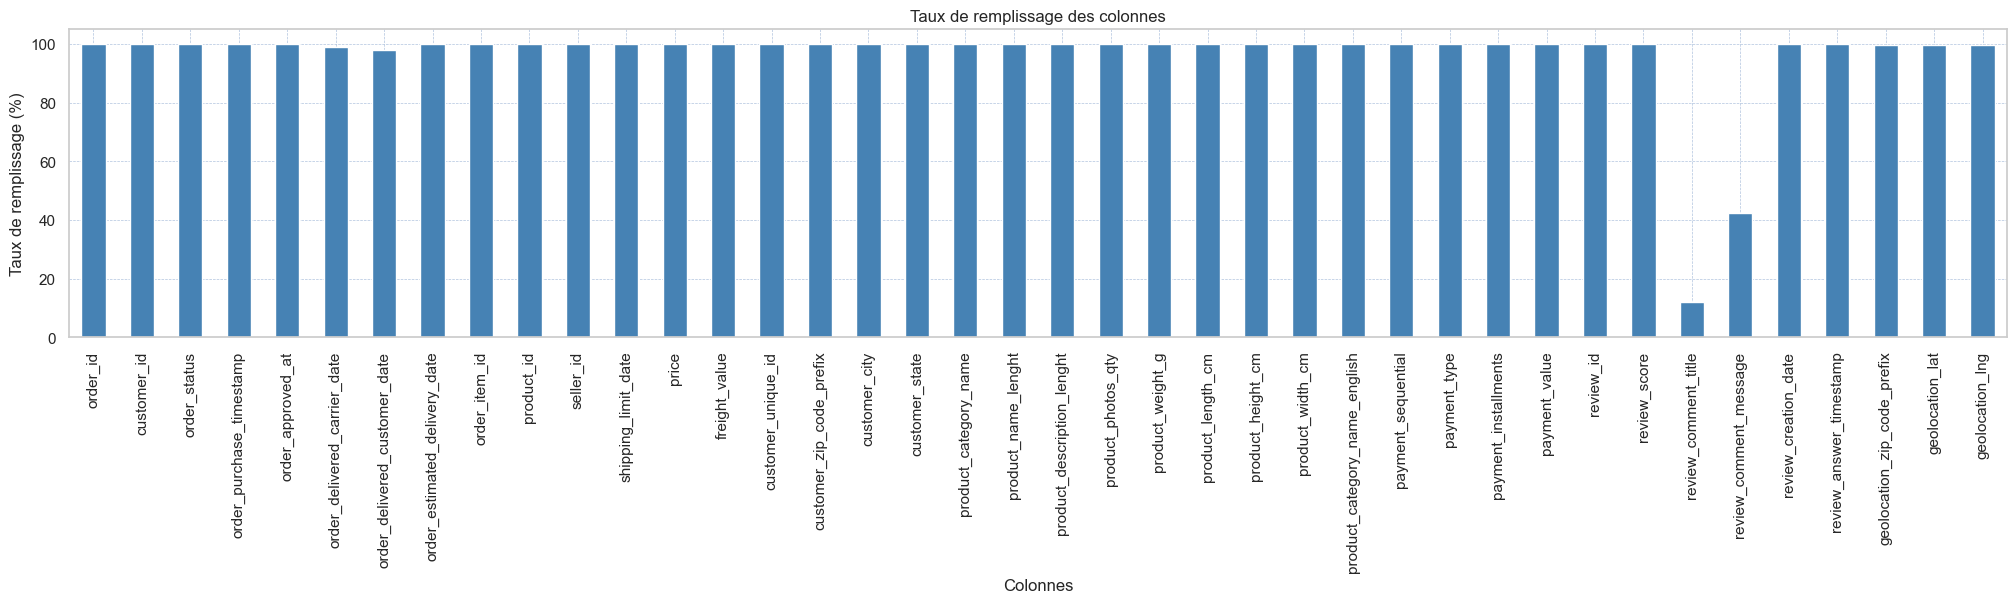

In [11]:
fill_rates_plot(data)

In [12]:
data_info(data)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
order_id,115609,96516,object,0,0.00
customer_id,115609,96516,object,0,0.00
order_status,115609,7,object,0,0.00
order_purchase_timestamp,115609,95989,object,0,0.00
order_approved_at,115595,88332,object,14,0.01
order_delivered_carrier_date,114414,79241,object,1195,1.03
order_delivered_customer_date,113209,93702,object,2400,2.08
order_estimated_delivery_date,115609,449,object,0,0.00
order_item_id,115609,21,int64,0,0.00


- Changement des types incohérents

In [13]:
columns_to_convert = ['order_purchase_timestamp', 
                      'order_delivered_carrier_date', 
                      'order_delivered_customer_date', 
                      'order_estimated_delivery_date']

In [14]:
for column in columns_to_convert:
    data[column] = pd.to_datetime(data[column])

- Observation des features

In [15]:
features_list = data.columns.tolist()
for feature in features_list:
    print(feature)

order_id
customer_id
order_status
order_purchase_timestamp
order_approved_at
order_delivered_carrier_date
order_delivered_customer_date
order_estimated_delivery_date
order_item_id
product_id
seller_id
shipping_limit_date
price
freight_value
customer_unique_id
customer_zip_code_prefix
customer_city
customer_state
product_category_name
product_name_lenght
product_description_lenght
product_photos_qty
product_weight_g
product_length_cm
product_height_cm
product_width_cm
product_category_name_english
payment_sequential
payment_type
payment_installments
payment_value
review_id
review_score
review_comment_title
review_comment_message
review_creation_date
review_answer_timestamp
geolocation_zip_code_prefix
geolocation_lat
geolocation_lng


In [16]:
columns_to_drop = ['order_approved_at', 'shipping_limit_date','product_category_name',
                   'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
                   'review_comment_title', 'review_comment_message', 'review_creation_date',
                   'review_answer_timestamp']

In [17]:
data = data.drop(columns=columns_to_drop)
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,...,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,housewares,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,3149.0,-23.576983,-46.587161
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,housewares,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,3149.0,-23.576983,-46.587161
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,housewares,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,3149.0,-23.576983,-46.587161
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,housewares,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,3366.0,-23.564630,-46.534268
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,housewares,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,2290.0,-23.600462,-46.655318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,0b82d0616f1ad8da15cf967b984b4004,986632b40c38f4240caf8608cb01d40d,delivered,2018-08-03 21:35:53,2018-08-08 14:26:00,2018-08-09 21:42:08,2018-08-10,1,4a24717893a6c8f3cfcf9843b8987d15,2cb6eb1b7185064167657fa09f541105,...,arts_and_craftmanship,1,boleto,1,33.69,dbcc8337677aaefa8a711819880d4cf9,5,30575.0,-19.973801,-43.972640
115605,2ef4a11b6e24fdfbb43b92cb5f95edff,ee1cfdc92e449920e25d3ca4ab4da4f6,delivered,2018-07-23 18:35:14,2018-07-24 14:37:00,2018-07-27 14:04:10,2018-08-06,1,9c313adb4b38a55b092f53f83f78be9e,ef728fa1f17436c91ed1ccd03dcf9631,...,arts_and_craftmanship,1,credit_card,1,84.63,ad0de1dda4fa03e8efb68c481b31ebf8,3,9951.0,-23.689006,-46.590933
115606,2ef4a11b6e24fdfbb43b92cb5f95edff,ee1cfdc92e449920e25d3ca4ab4da4f6,delivered,2018-07-23 18:35:14,2018-07-24 14:37:00,2018-07-27 14:04:10,2018-08-06,2,eacb104882d39ffb53140b1d1860a7c3,ef728fa1f17436c91ed1ccd03dcf9631,...,arts_and_craftmanship,1,credit_card,1,84.63,ad0de1dda4fa03e8efb68c481b31ebf8,3,9951.0,-23.689006,-46.590933
115607,2c4ada2e75c2ad41dd93cebb5df5f023,363d3a9b2ec5c5426608688ca033292d,delivered,2017-01-26 11:09:00,2017-01-27 14:59:35,2017-02-14 16:24:01,2017-03-07,1,6c7a0a349ad11817745e3ad58abd5c79,48162d548f5b1b11b9d29d1e01f75a61,...,security_and_services,1,credit_card,1,209.06,82ec4a1c6f0134f607033e23431ee298,4,76940.0,-11.722454,-61.777036


- Observations statistiques

In [18]:
data.describe()

,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,price,freight_value,customer_zip_code_prefix,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,review_score,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,115609,114414,113209,115609,115609.000000,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609.000000,115609.000000,115609.000000,115609.000000,115299.000000,115299.000000,115299.000000
mean,2017-12-31 04:27:50.933335296,2018-01-04 05:48:14.275464704,2018-01-13 17:20:24.922400,2018-01-24 01:15:13.973825536,1.194535,120.619850,20.056880,35061.537597,2113.907697,30.307903,16.638477,23.113167,1.093747,2.946233,172.387379,4.034409,34984.829695,-21.234484,-46.196654
min,2016-09-04 21:15:19,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-20 00:00:00,1.000000,0.850000,0.000000,1003.000000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1.000000,1003.000000,-33.689948,-72.668881
25%,2017-09-12 11:14:11,2017-09-15 17:37:49,2017-09-25 18:12:25,2017-10-03 00:00:00,1.000000,39.900000,13.080000,11310.000000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.870000,4.000000,11250.000000,-23.590298,-48.104959
50%,2018-01-19 03:30:43,2018-01-23 23:48:29,2018-02-02 01:42:36,2018-02-15 00:00:00,1.000000,74.900000,16.320000,24241.000000,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.050000,5.000000,24230.000000,-22.928999,-46.631777
75%,2018-05-04 15:56:31,2018-05-08 13:01:00,2018-05-15 19:54:56,2018-05-28 00:00:00,1.000000,134.900000,21.210000,58745.000000,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,189.480000,5.000000,58300.500000,-20.182732,-43.622642
max,2018-09-03 09:06:57,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,21.000000,6735.000000,409.680000,99980.000000,40425.000000,105.000000,105.000000,118.000000,29.000000,24.000000,13664.080000,5.000000,99980.000000,42.184003,-8.723762
std,NaN,NaN,NaN,NaN,0.685926,182.653476,15.836184,29841.671732,3781.754895,16.211108,13.473570,11.755083,0.729849,2.781087,265.873969,1.385584,29828.821758,5.563683,4.043692


- Observation des valeurs manquantes

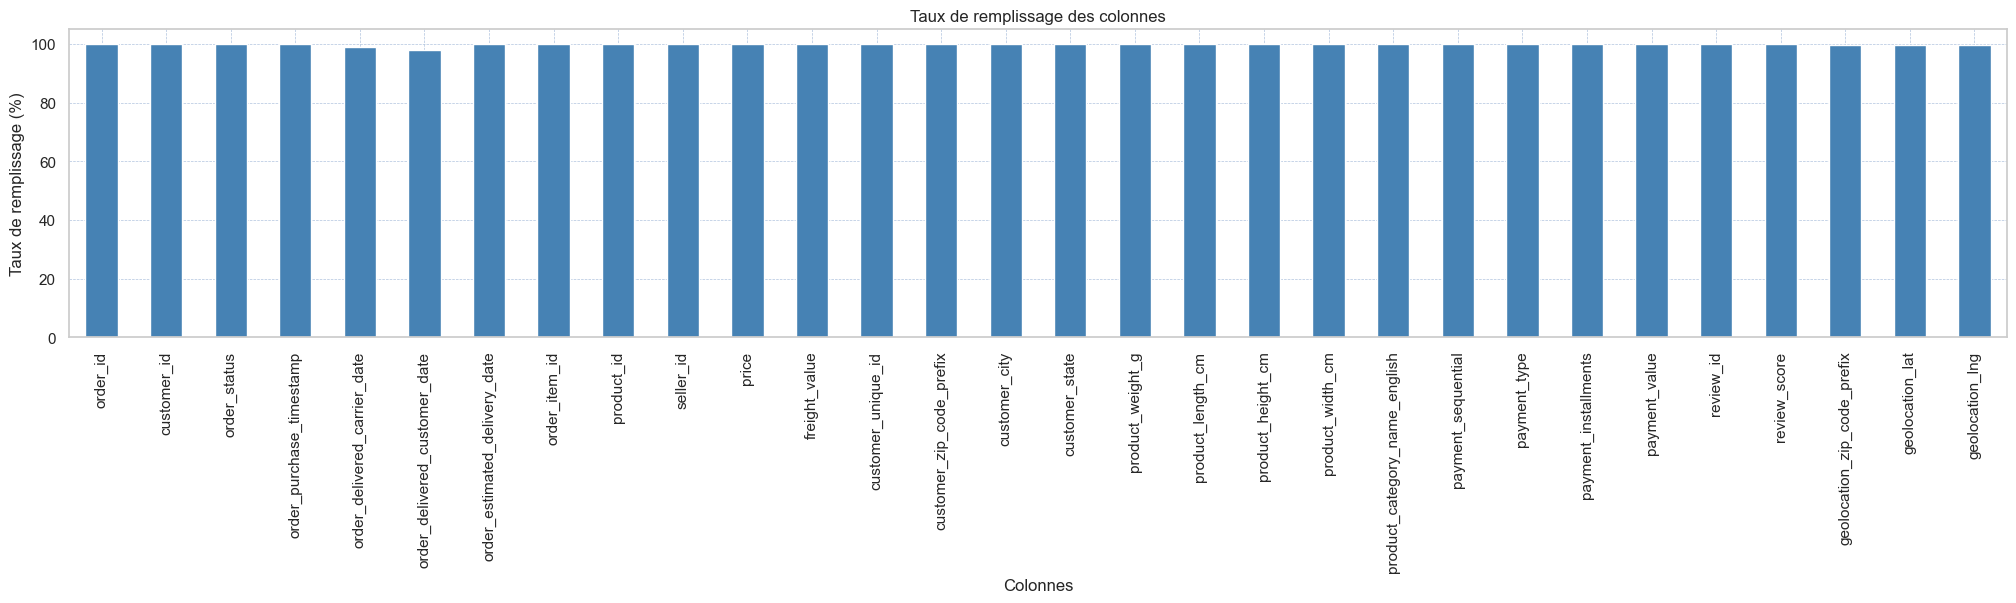

In [19]:
fill_rates_plot(data)

In [20]:
data_info(data)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
order_id,115609,96516,object,0,0.00
customer_id,115609,96516,object,0,0.00
order_status,115609,7,object,0,0.00
order_purchase_timestamp,115609,95989,datetime64[ns],0,0.00
order_delivered_carrier_date,114414,79241,datetime64[ns],1195,1.03
order_delivered_customer_date,113209,93702,datetime64[ns],2400,2.08
order_estimated_delivery_date,115609,449,datetime64[ns],0,0.00
order_item_id,115609,21,int64,0,0.00
product_id,115609,32171,object,0,0.00


In [21]:
data.dropna(inplace=True)

## <a name="C4"> Analyse exploratoire</a>

### Analyse des variables quantitatives

- Analyse statistique des distributions

colonne 'order_item_id':
moyenne: 1.20
mediane: 1.00
ecart_type: 0.69
Variance: 0.47
Minimum: 1.00
Maximum: 21.00
quantile_25 25%: 1.00
quantile_75 75%: 1.00


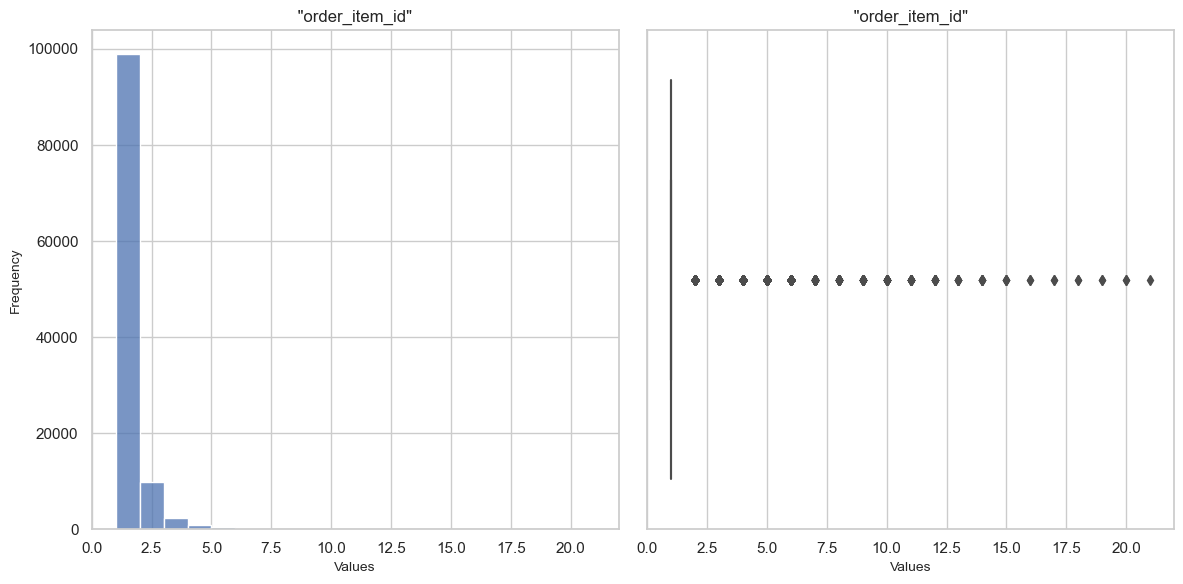

colonne 'price':
moyenne: 119.83
mediane: 74.90
ecart_type: 181.10
Variance: 32796.58
Minimum: 0.85
Maximum: 6735.00
quantile_25 25%: 39.90
quantile_75 75%: 132.97


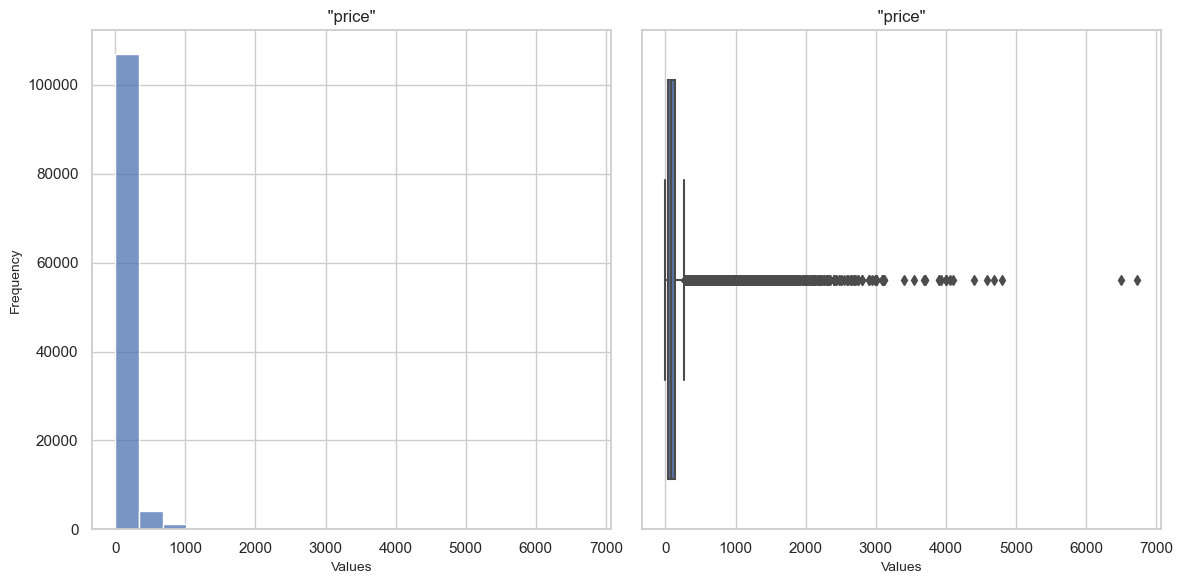

colonne 'freight_value':
moyenne: 20.00
mediane: 16.32
ecart_type: 15.71
Variance: 246.92
Minimum: 0.00
Maximum: 409.68
quantile_25 25%: 13.08
quantile_75 75%: 21.18


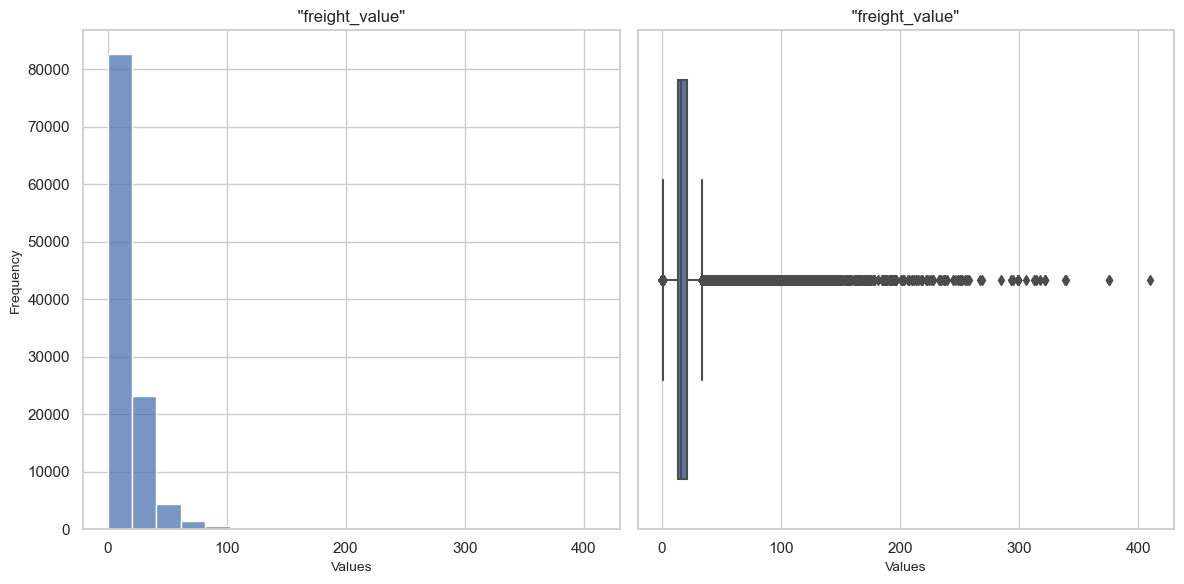

colonne 'customer_zip_code_prefix':
moyenne: 35011.04
mediane: 24230.00
ecart_type: 29855.18
Variance: 891331565.98
Minimum: 1003.00
Maximum: 99980.00
quantile_25 25%: 11133.75
quantile_75 75%: 58401.00


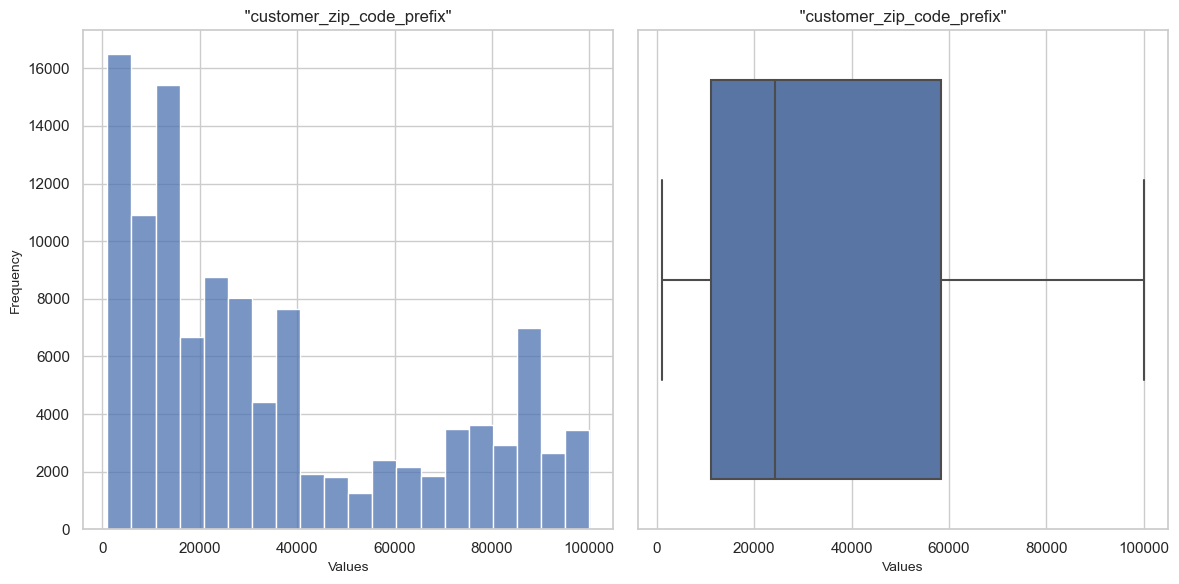

colonne 'product_weight_g':
moyenne: 2107.17
mediane: 700.00
ecart_type: 3766.76
Variance: 14188443.40
Minimum: 0.00
Maximum: 40425.00
quantile_25 25%: 300.00
quantile_75 75%: 1800.00


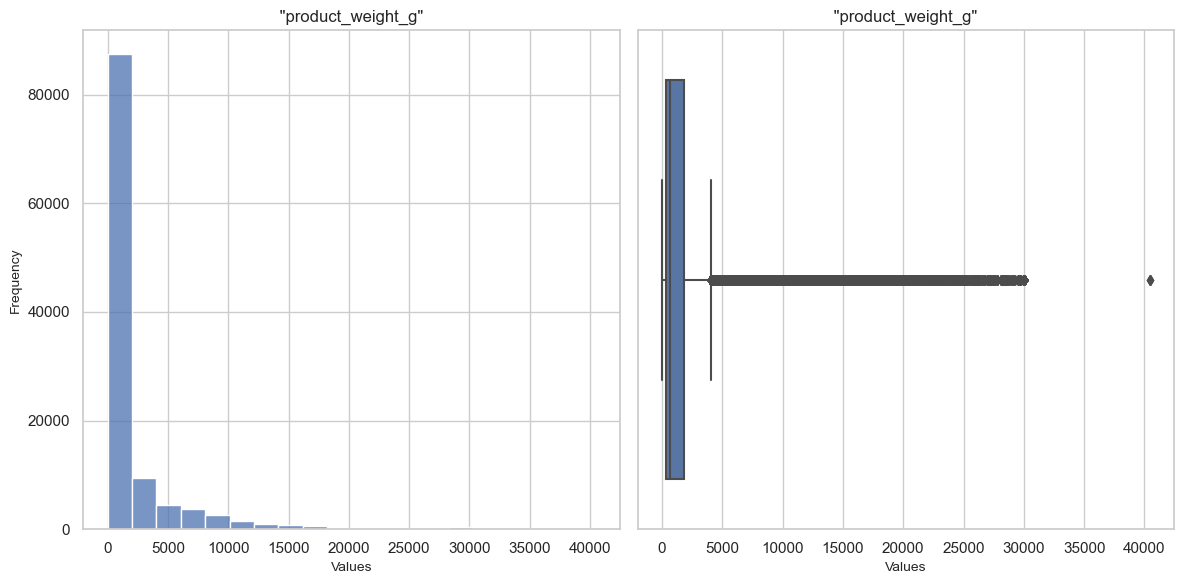

colonne 'product_length_cm':
moyenne: 30.28
mediane: 25.00
ecart_type: 16.15
Variance: 260.67
Minimum: 7.00
Maximum: 105.00
quantile_25 25%: 18.00
quantile_75 75%: 38.00


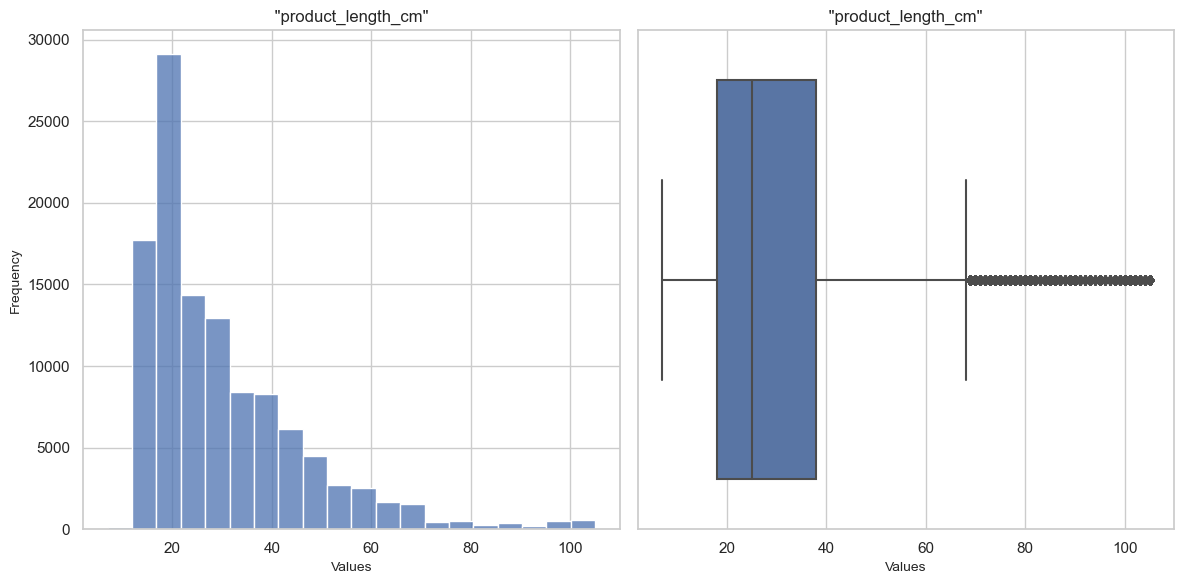

colonne 'product_height_cm':
moyenne: 16.60
mediane: 13.00
ecart_type: 13.44
Variance: 180.61
Minimum: 2.00
Maximum: 105.00
quantile_25 25%: 8.00
quantile_75 75%: 20.00


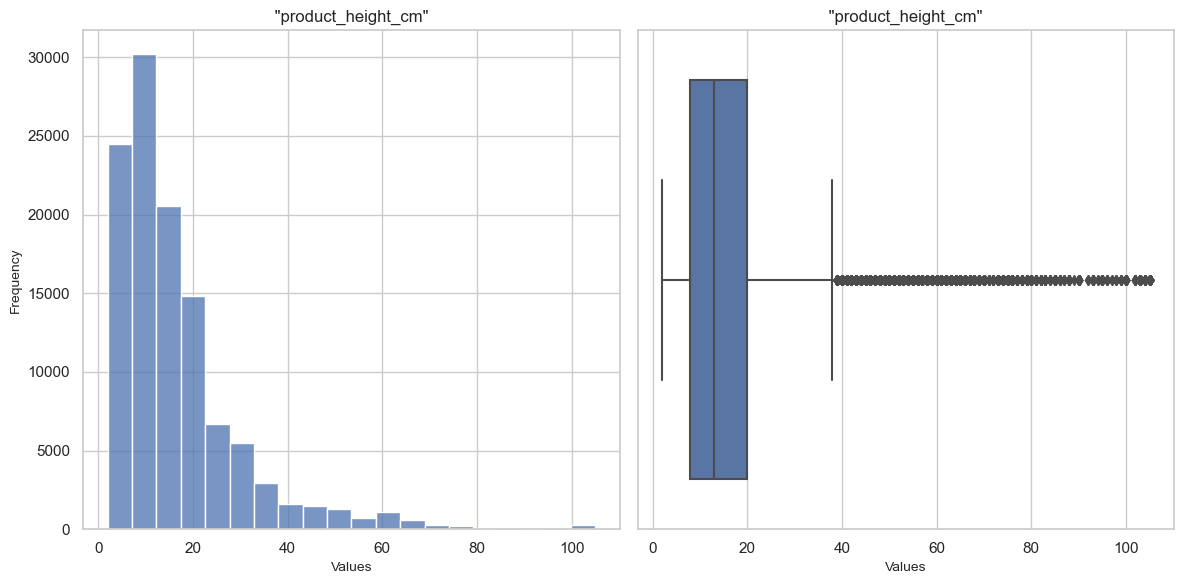

colonne 'product_width_cm':
moyenne: 23.10
mediane: 20.00
ecart_type: 11.73
Variance: 137.71
Minimum: 6.00
Maximum: 118.00
quantile_25 25%: 15.00
quantile_75 75%: 30.00


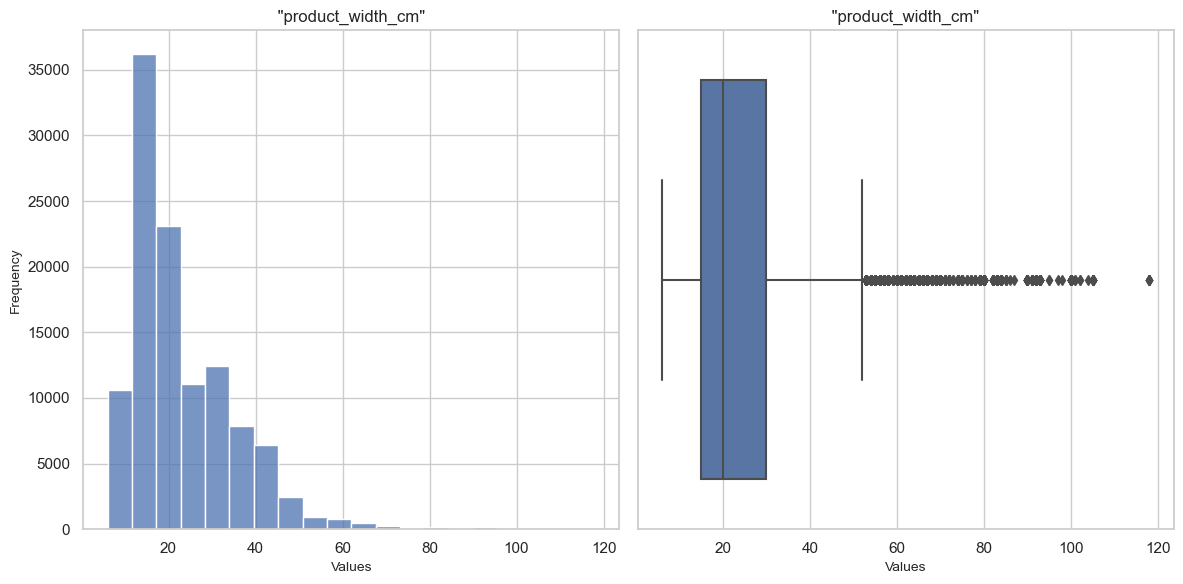

colonne 'payment_sequential':
moyenne: 1.09
mediane: 1.00
ecart_type: 0.69
Variance: 0.47
Minimum: 1.00
Maximum: 26.00
quantile_25 25%: 1.00
quantile_75 75%: 1.00


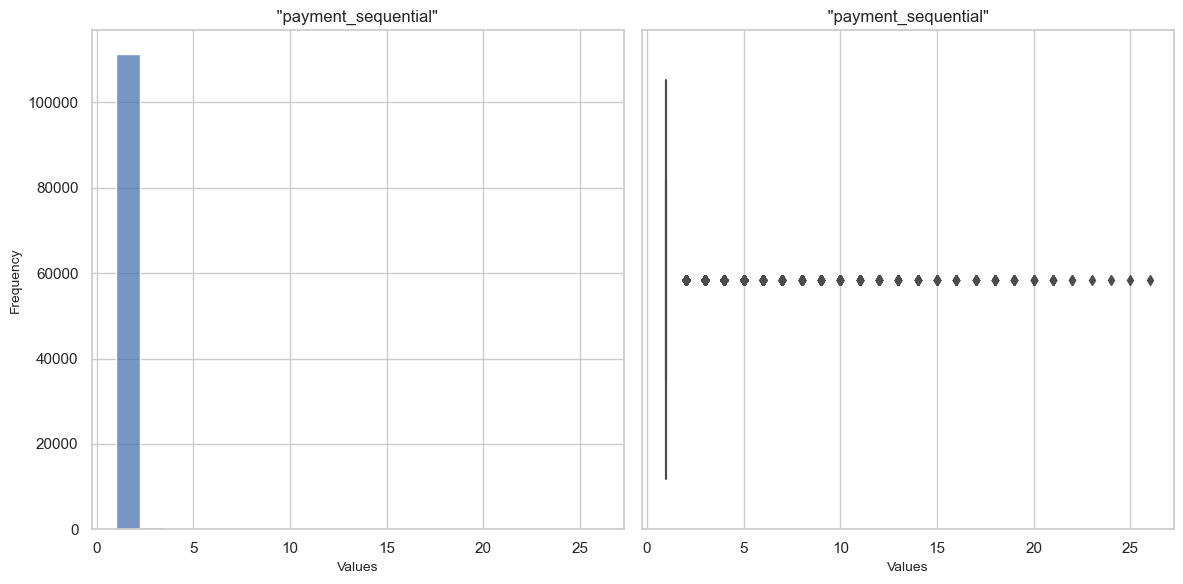

colonne 'payment_installments':
moyenne: 2.94
mediane: 2.00
ecart_type: 2.78
Variance: 7.72
Minimum: 0.00
Maximum: 24.00
quantile_25 25%: 1.00
quantile_75 75%: 4.00


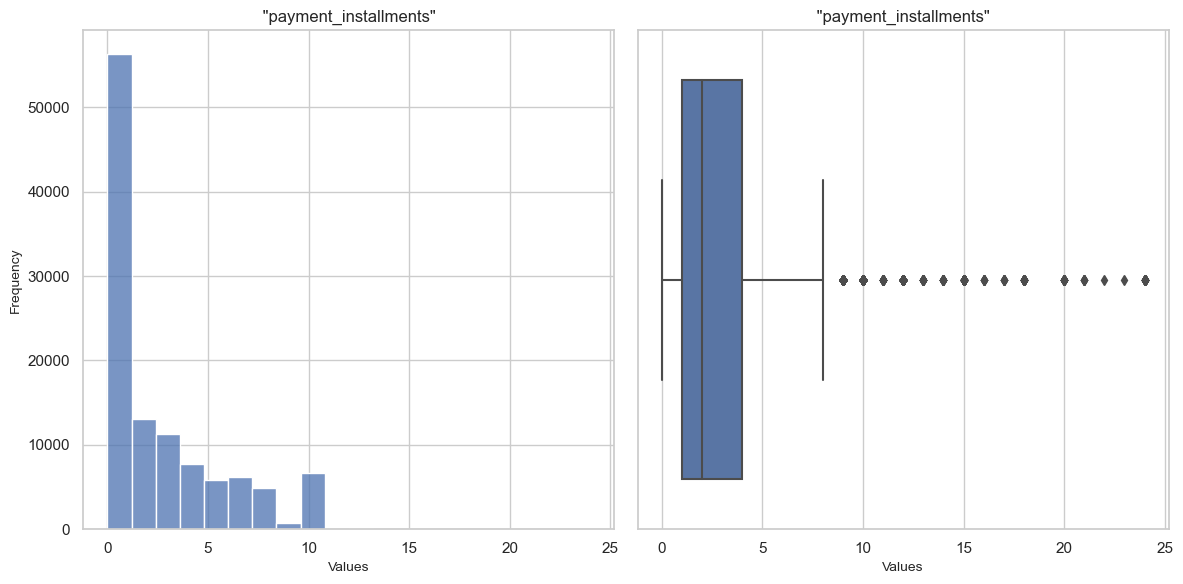

colonne 'payment_value':
moyenne: 171.55
mediane: 108.00
ecart_type: 264.31
Variance: 69857.41
Minimum: 0.00
Maximum: 13664.08
quantile_25 25%: 60.85
quantile_75 75%: 189.08


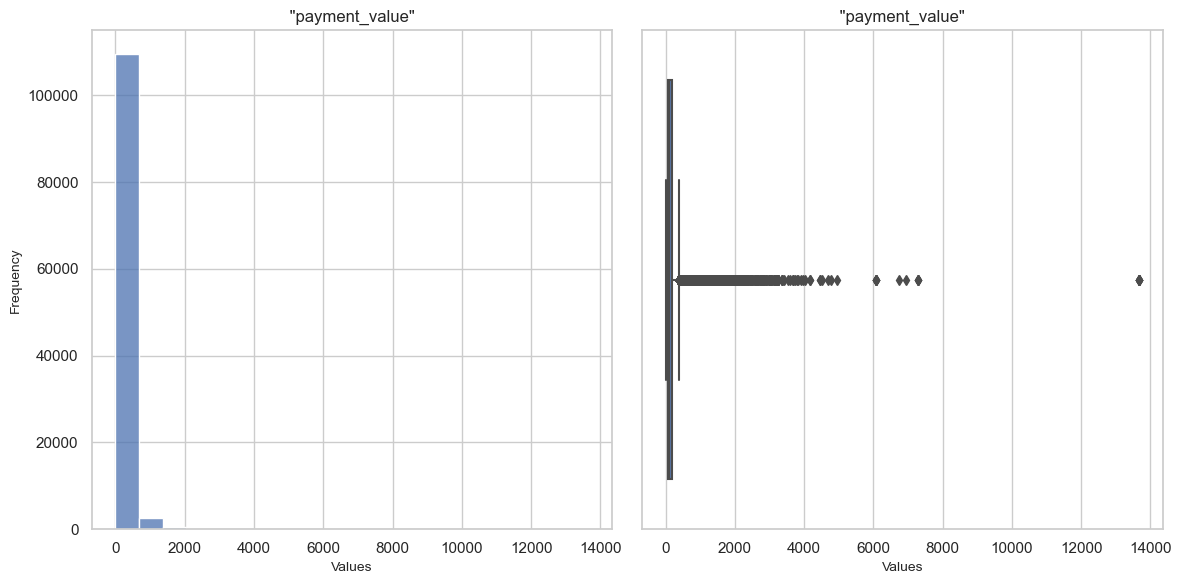

colonne 'review_score':
moyenne: 4.08
mediane: 5.00
ecart_type: 1.35
Variance: 1.81
Minimum: 1.00
Maximum: 5.00
quantile_25 25%: 4.00
quantile_75 75%: 5.00


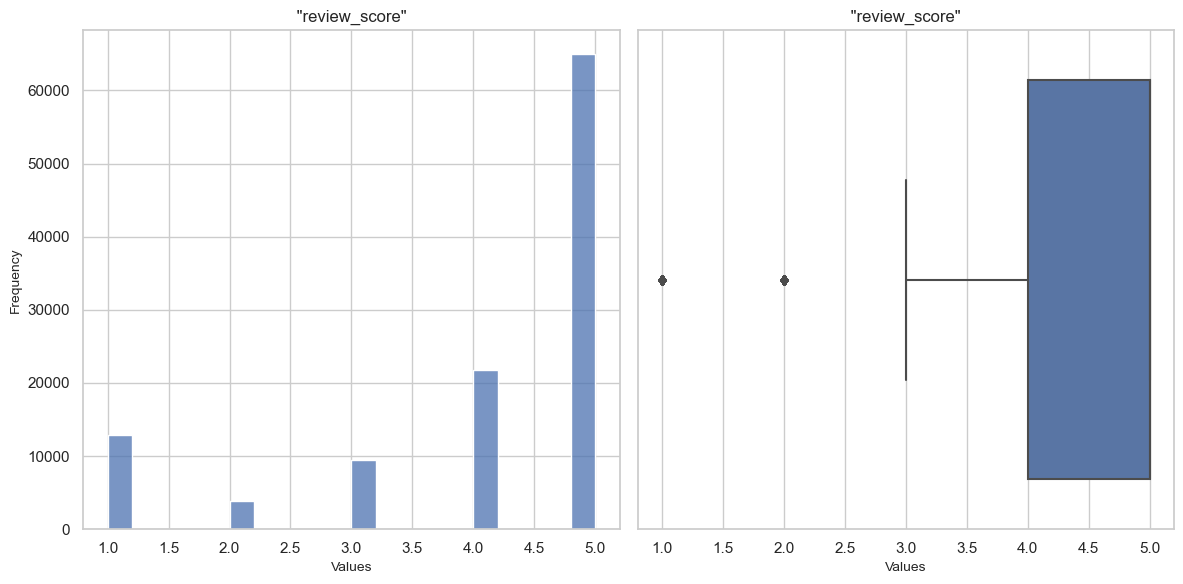

colonne 'geolocation_zip_code_prefix':
moyenne: 35011.04
mediane: 24230.00
ecart_type: 29855.18
Variance: 891331565.98
Minimum: 1003.00
Maximum: 99980.00
quantile_25 25%: 11133.75
quantile_75 75%: 58401.00


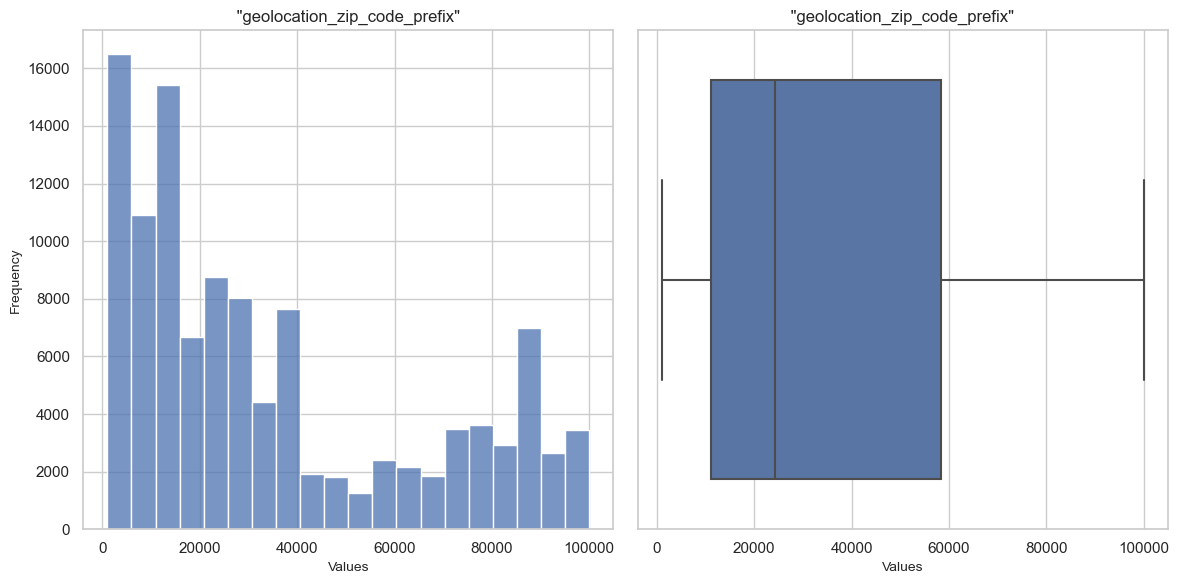

colonne 'geolocation_lat':
moyenne: -21.25
mediane: -22.93
ecart_type: 5.55
Variance: 30.85
Minimum: -33.69
Maximum: 42.18
quantile_25 25%: -23.59
quantile_75 75%: -20.20


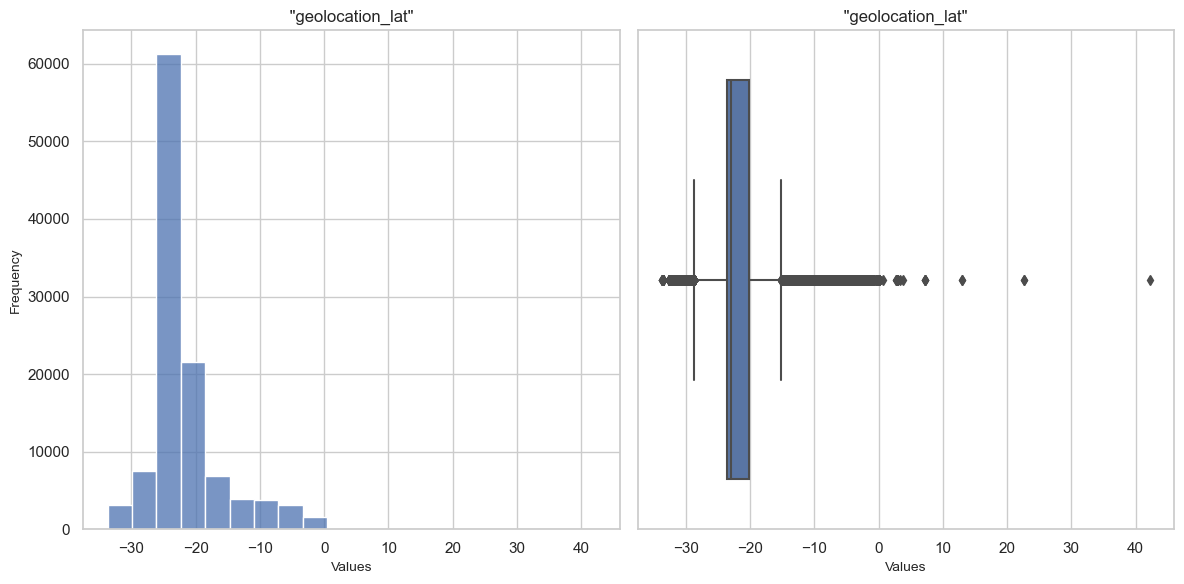

colonne 'geolocation_lng':
moyenne: -46.21
mediane: -46.63
ecart_type: 4.04
Variance: 16.32
Minimum: -72.67
Maximum: -8.72
quantile_25 25%: -48.11
quantile_75 75%: -43.65


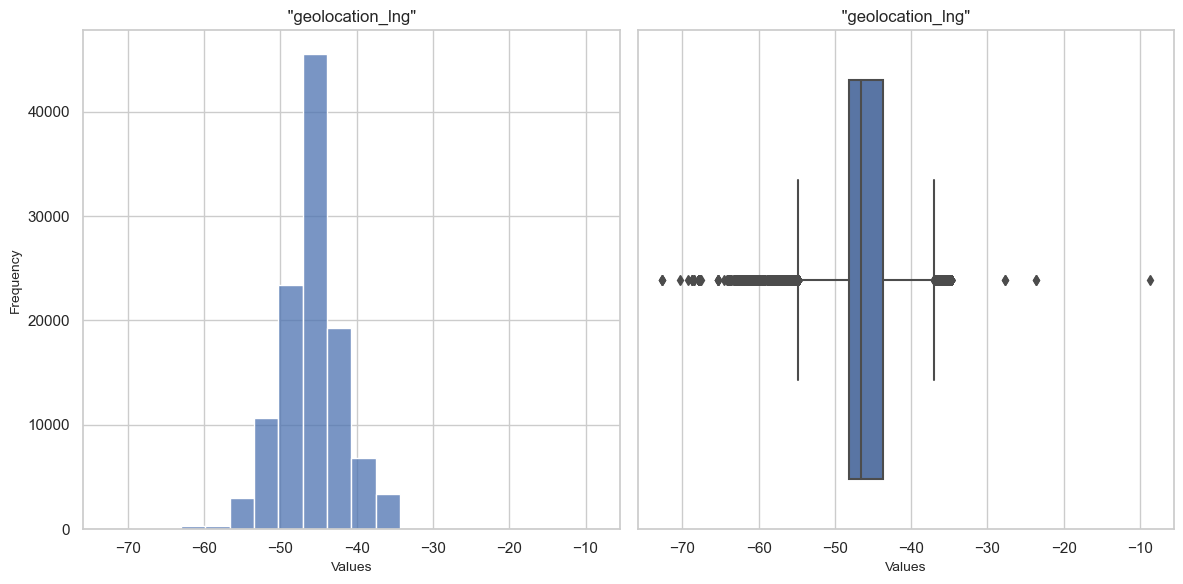

In [22]:
numeric_columns = data.select_dtypes(include=[np.number])
      
for colonne in numeric_columns.columns:
        moyenne = numeric_columns[colonne].mean()
        mediane = numeric_columns[colonne].median()
        ecart_type = numeric_columns[colonne].std()
        variance = numeric_columns[colonne].var()
        minimum = numeric_columns[colonne].min()
        maximum = numeric_columns[colonne].max()
        quantile_25 = numeric_columns[colonne].quantile(0.25)
        quantile_75 = numeric_columns[colonne].quantile(0.75)
        
        print(f"colonne '{colonne}':")
        print(f"moyenne: {moyenne:.2f}")
        print(f"mediane: {mediane:.2f}")
        print(f"ecart_type: {ecart_type:.2f}")
        print(f"Variance: {variance:.2f}")
        print(f"Minimum: {minimum:.2f}")
        print(f"Maximum: {maximum:.2f}")
        print(f"quantile_25 25%: {quantile_25:.2f}")
        print(f"quantile_75 75%: {quantile_75:.2f}")
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        sns.histplot(data=data, x=colonne, bins=20, kde=False, ax=axes[0])
        axes[0].set_title(f' "{colonne}" ', fontsize=12)
        axes[0].set_xlabel('Values', fontsize=10)
        axes[0].set_ylabel('Frequency', fontsize=10)
        
        # Boxplot
        sns.boxplot(data=data, x=colonne, orient='h', ax=axes[1])
        axes[1].set_title(f' "{colonne}" ', fontsize=12)
        axes[1].set_xlabel('Values', fontsize=10)
        
        plt.tight_layout()
        plt.show()


- Analyse des commandes

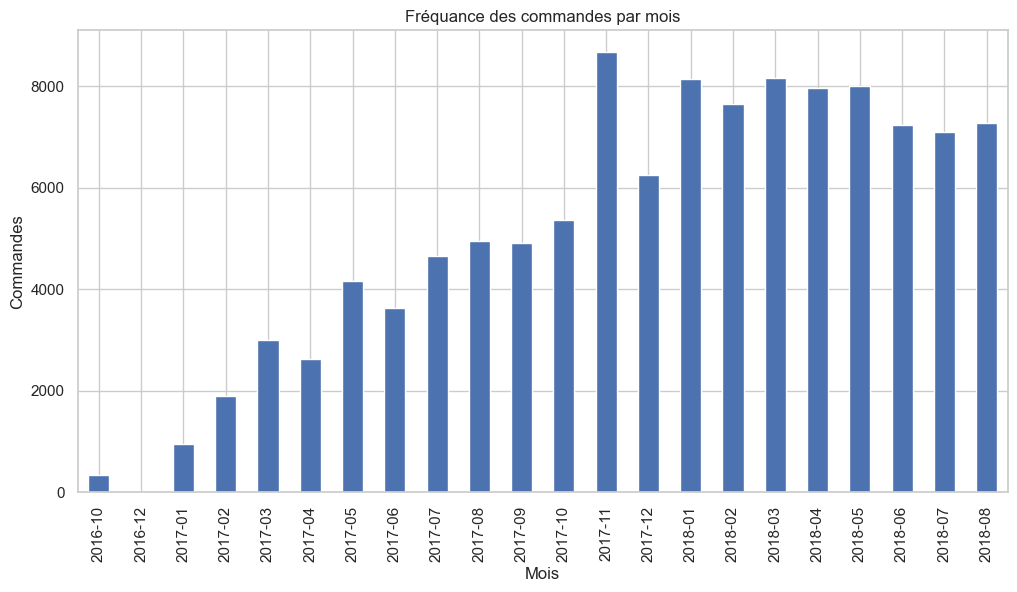

In [23]:
plt.figure(figsize=(12, 6))
data['order_purchase_timestamp'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')
plt.title("Fréquance des commandes par mois")
plt.xlabel("Mois")
plt.ylabel("Commandes")
plt.show()

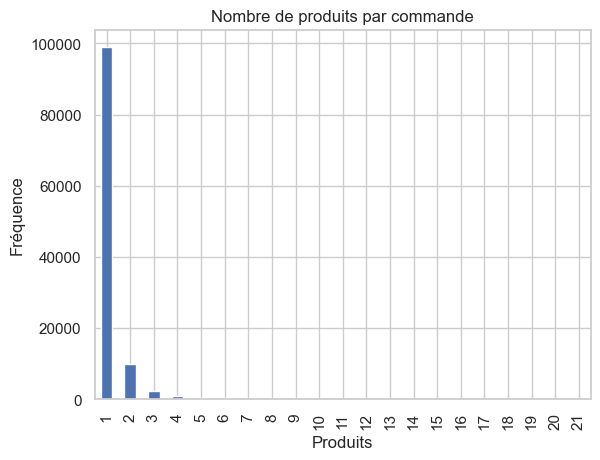

In [24]:
data['order_item_id'].value_counts().sort_index().plot(kind='bar')
plt.title("Nombre de produits par commande")
plt.xlabel("Produits")
plt.ylabel("Fréquence")
plt.show()

- Analyse des délais de livraison

In [25]:
# delivery delay in days
data['delivery_delay'] = (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days

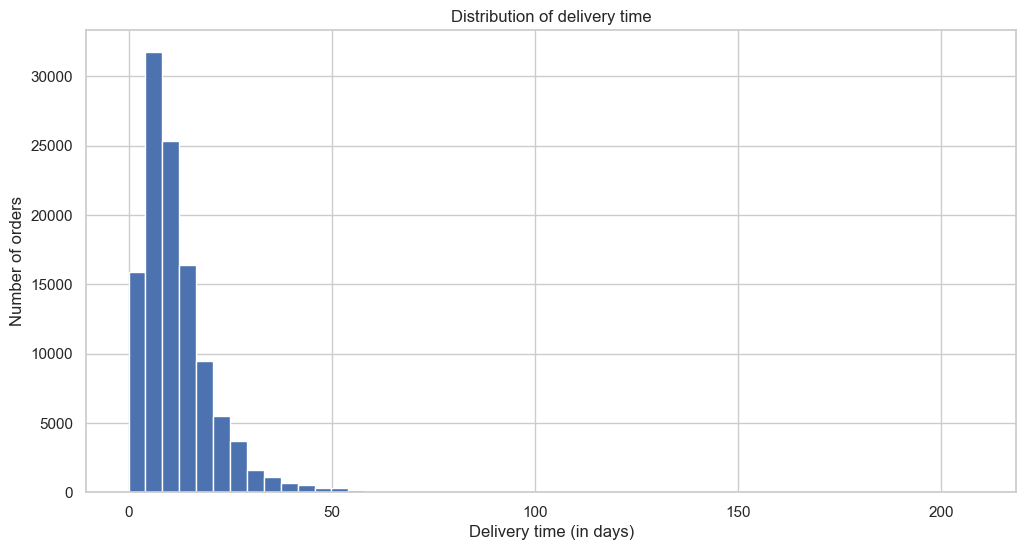

In [26]:
plt.figure(figsize=(12, 6))
plt.hist(data['delivery_delay'], bins=50)
plt.title('Distribution of delivery time')
plt.xlabel('Delivery time (in days)')
plt.ylabel('Number of orders')
plt.show()

### Analyse des variables qualitatives

- Analyse des catégories

In [27]:
category_counts = data['product_category_name_english'].value_counts()
len(category_counts)

71

In [28]:
category_counts_sorted = category_counts.sort_values(ascending=False)
category_counts_sorted

product_category_name_english
bed_bath_table               11658
health_beauty                 9721
sports_leisure                8720
furniture_decor               8539
computers_accessories         7901
                             ...  
arts_and_craftmanship           24
la_cuisine                      15
cds_dvds_musicals               14
fashion_childrens_clothes        7
security_and_services            2
Name: count, Length: 71, dtype: int64

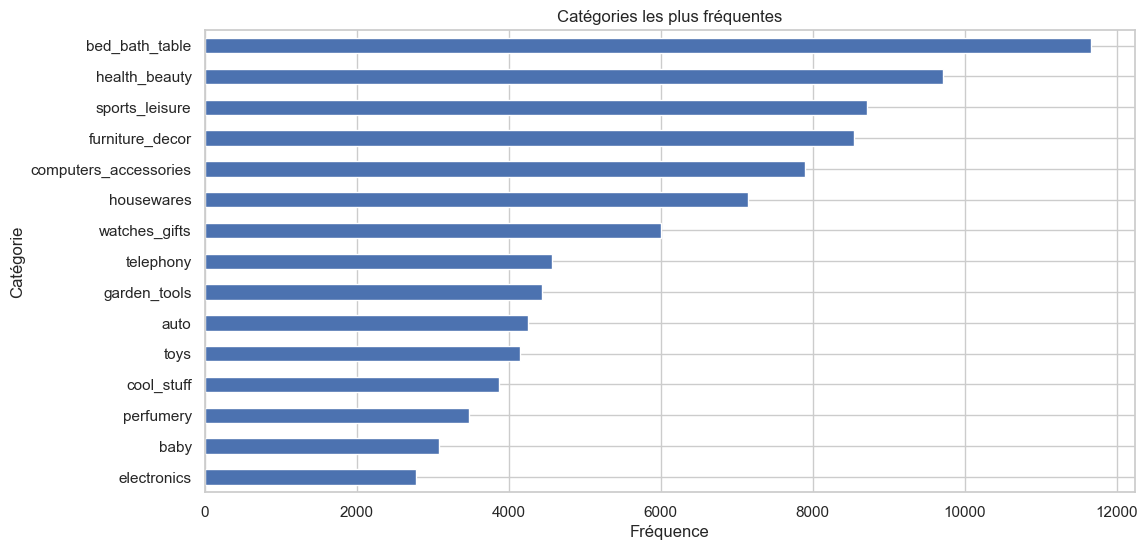

In [29]:
top_categories = category_counts_sorted.head(15)
top_categories = top_categories.iloc[::-1]

plt.figure(figsize=(12, 6))
top_categories.plot(kind='barh')
plt.title('Catégories les plus fréquentes')
plt.xlabel('Fréquence')
plt.ylabel('Catégorie')
plt.show()

- Analyse des moyens de paiement

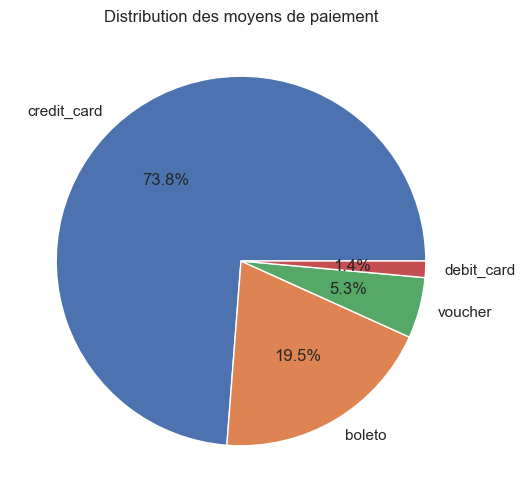

In [30]:
payment_counts = data['payment_type'].value_counts()

plt.figure(figsize=(6, 6)) 
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%',)
plt.title('Distribution des moyens de paiement')
plt.show()

- Analyse des statuts des commandes

In [31]:
order_status = data['order_status'].value_counts()
order_status

order_status
delivered    112903
canceled          7
Name: count, dtype: int64

In [32]:
data['customer_state'].nunique()

27

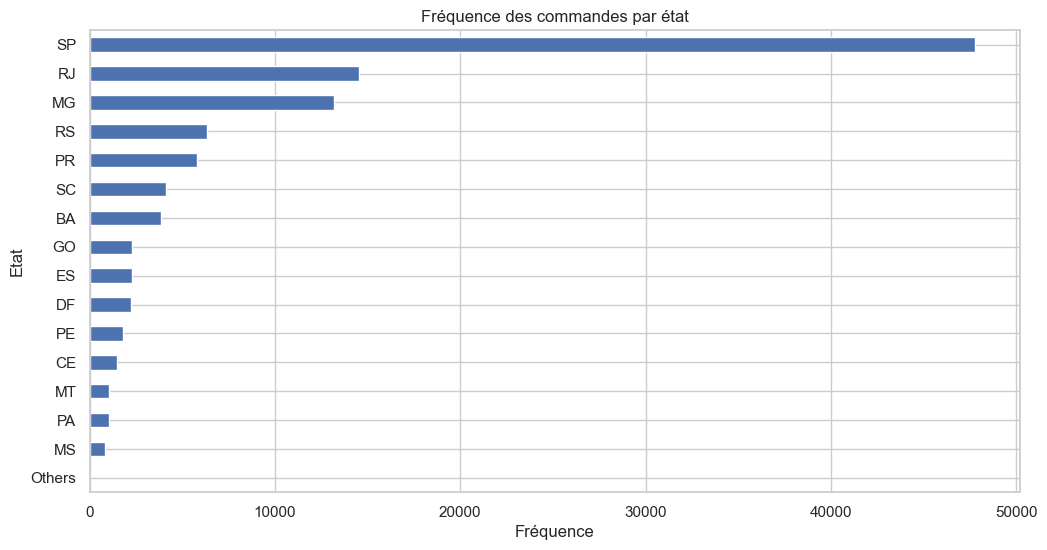

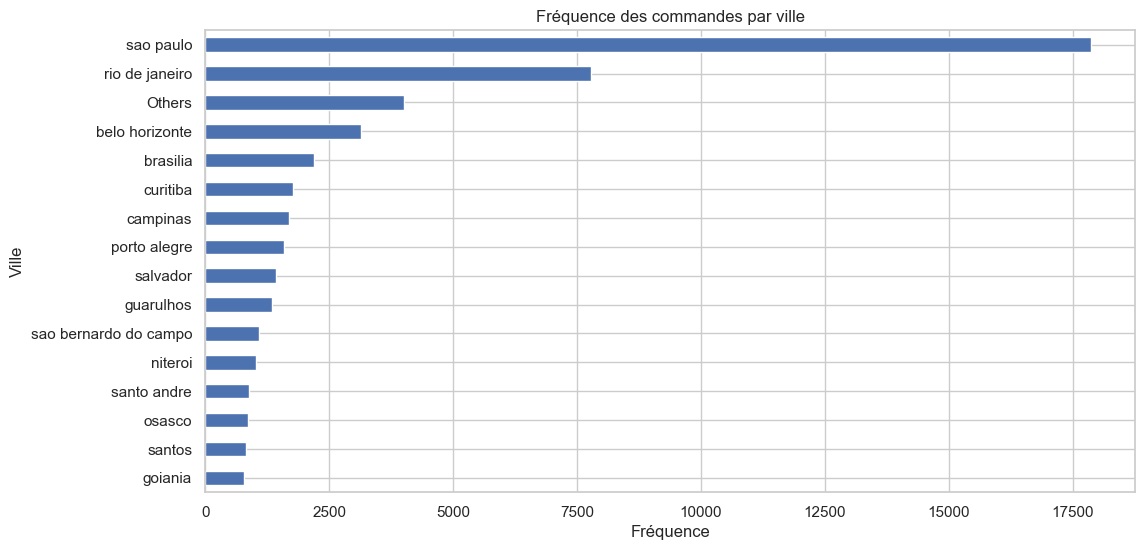

In [33]:
top_cities = data['customer_city'].value_counts().head(15) 
other_cities_count = data['customer_city'].nunique() - len(top_cities)
top_cities['Others'] = other_cities_count
top_cities = top_cities.sort_values(ascending=True)

top_states = data['customer_state'].value_counts().head(15)
other_states_count = data['customer_state'].nunique() - len(top_states)
top_states['Others'] = other_states_count
top_states = top_states.sort_values(ascending=True)

plt.figure(figsize=(12, 6))
top_states.plot(kind='barh')
plt.title("Fréquence des commandes par état")
plt.xlabel("Fréquence")
plt.ylabel("Etat")
plt.show()

plt.figure(figsize=(12, 6))
top_cities.plot(kind='barh')
plt.title("Fréquence des commandes par ville")
plt.xlabel("Fréquence")
plt.ylabel("Ville")
plt.show()



### Analyse bi-variée

- Clients, commandes et prix

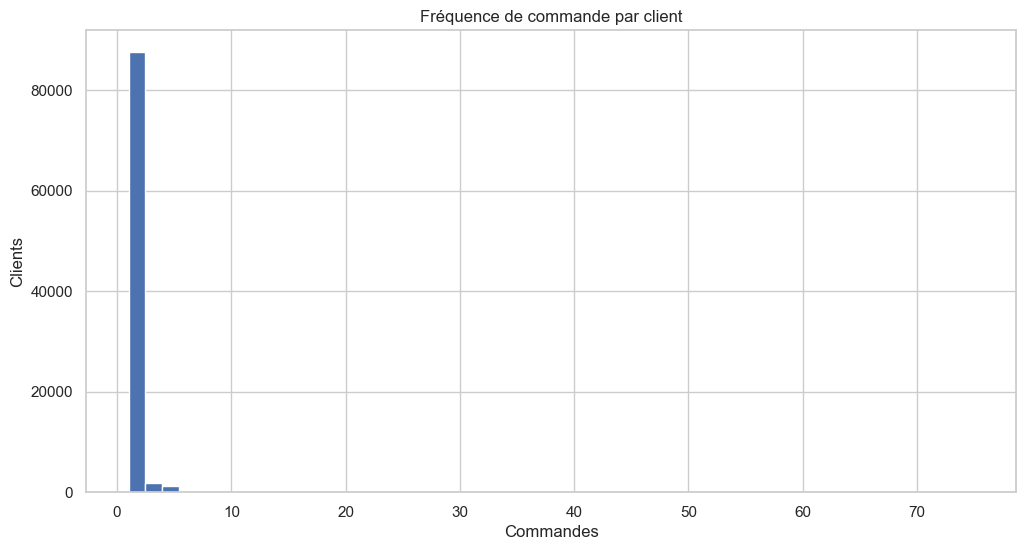

In [34]:
plt.figure(figsize=(12, 6))
transactions = data['customer_unique_id'].value_counts()
transactions.plot(kind='hist', bins=50)
plt.title("Fréquence de commande par client")
plt.xlabel("Commandes")
plt.ylabel("Clients")
plt.grid(True)
plt.show()

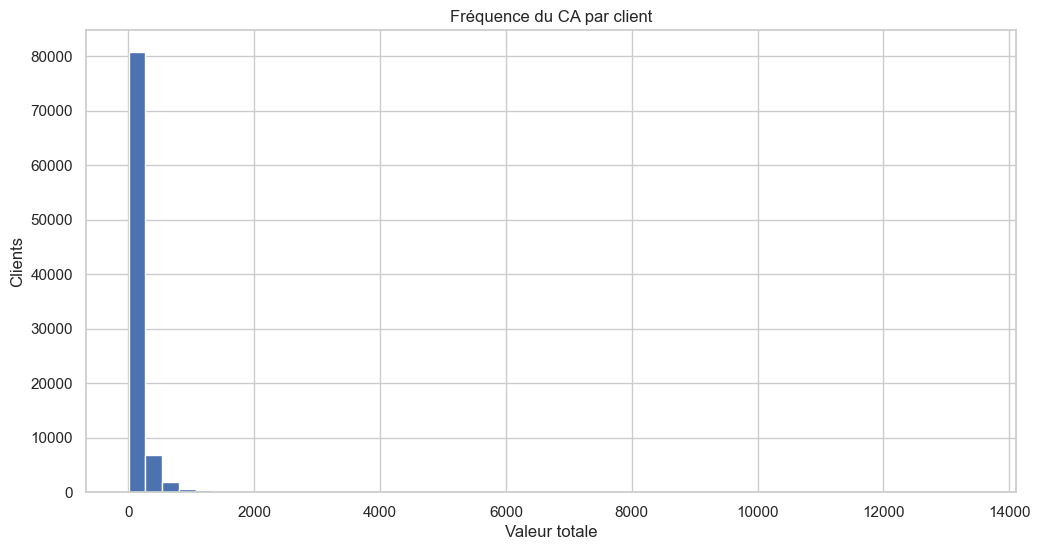

In [35]:
customer_value = data.groupby('customer_unique_id')['price'].sum()

plt.figure(figsize=(12, 6))
plt.hist(customer_value, bins=50)
plt.title("Fréquence du CA par client")
plt.xlabel("Valeur totale")
plt.ylabel("Clients")
plt.grid(True)
plt.show()

- Prix et Frais de port

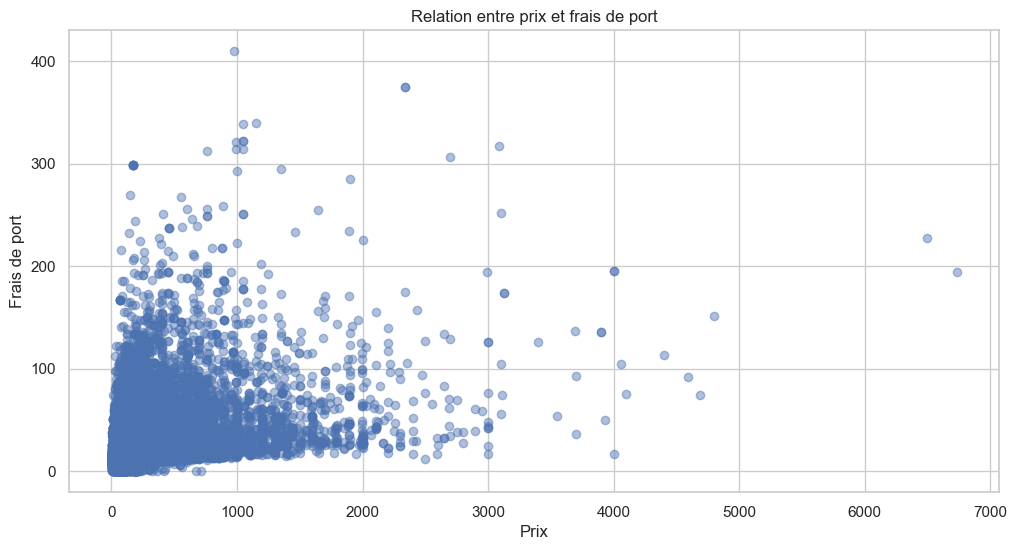

In [36]:
plt.figure(figsize=(12, 6))
plt.scatter(data['price'], data['freight_value'], alpha=0.45)
plt.title("Relation entre prix et frais de port")
plt.xlabel("Prix")
plt.ylabel("Frais de port")
plt.grid(True)
plt.show()

- Etat, prix et délai de livraison

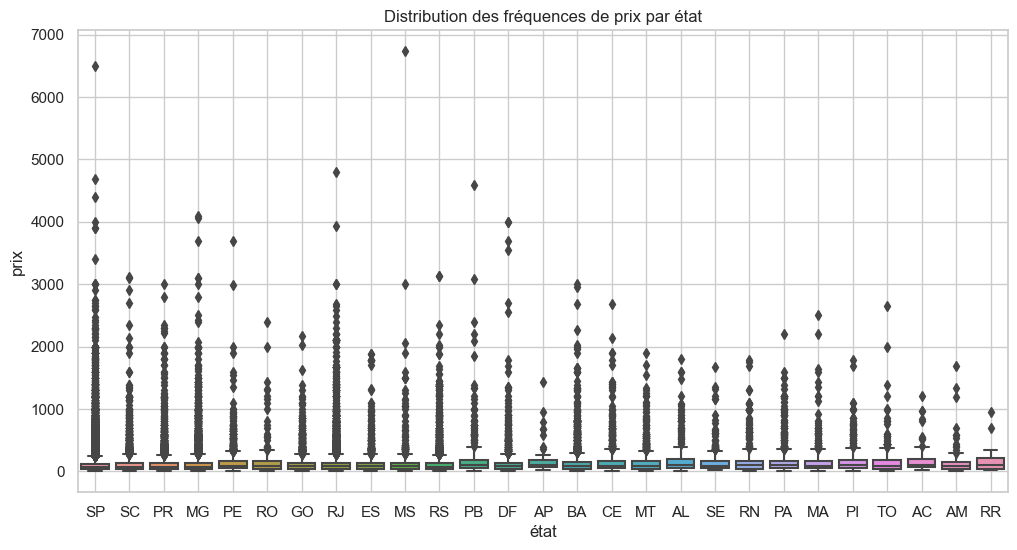

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='customer_state', y='price', data=data)
plt.title("Distribution des fréquences de prix par état")
plt.xlabel("état")
plt.ylabel("prix")
plt.grid(True)
plt.xticks()
plt.show()

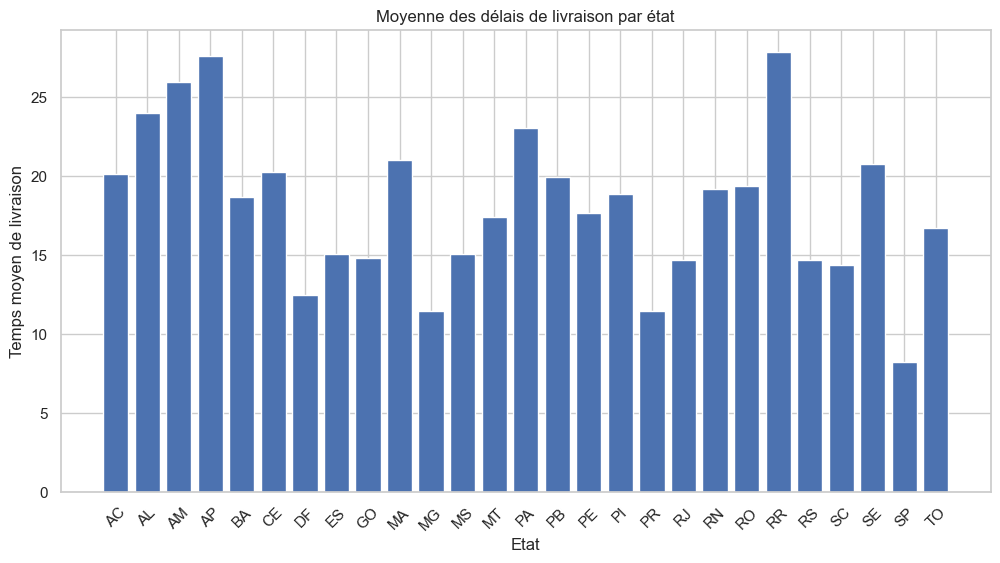

In [38]:
delivery_delay = data.groupby('customer_state')['delivery_delay'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(delivery_delay['customer_state'], delivery_delay['delivery_delay'])
plt.title('Moyenne des délais de livraison par état')
plt.xlabel('Etat')
plt.ylabel('Temps moyen de livraison')
plt.xticks(rotation=45)
plt.show()

### Analyse multi-variée

- Analyse des corrélations

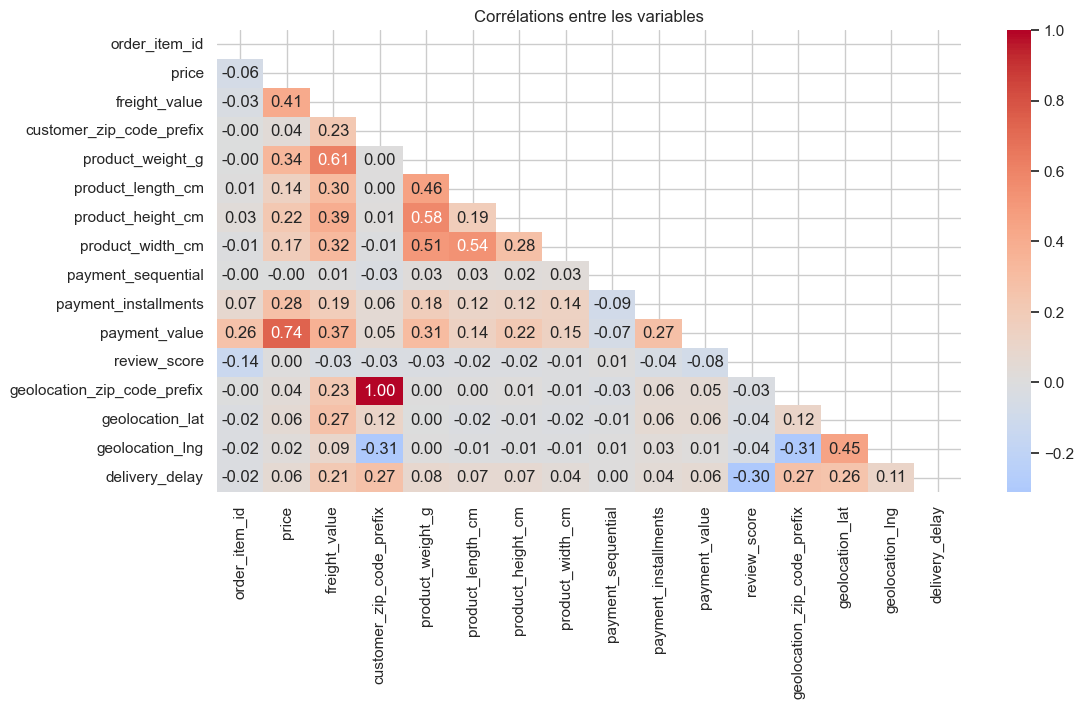

In [39]:
numeric_data = data.select_dtypes(include=['number'])
corr = numeric_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.heatmap(corr, annot=True,
                 fmt=".2f", 
                 mask=mask, 
                 center=0, 
                 cmap="coolwarm")
plt.title(f"Corrélations entre les variables")
plt.show()

- Analyse géographique

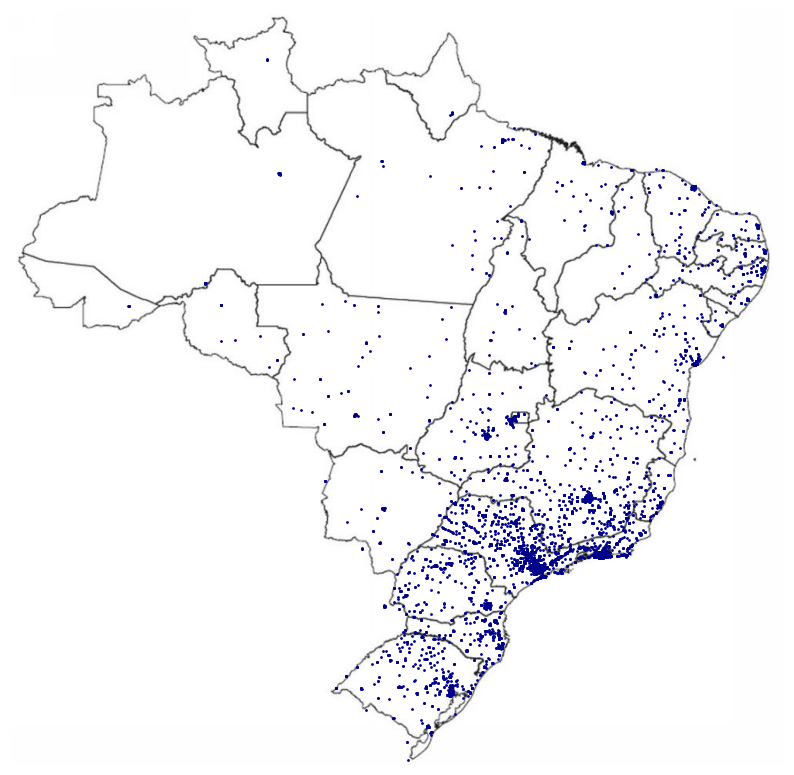

In [40]:
sample_size = 9000 #10% des clients
data_sample = data.sample(n=sample_size, random_state=42)
grouped_data = data_sample.groupby("customer_unique_id")

brazil = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
fig, ax = plt.subplots(figsize=(10, 10))

for name, group in grouped_data:
     ax.scatter(group["geolocation_lng"], group["geolocation_lat"], alpha=1, s=1, c='Darkblue')

ax.imshow(brazil, extent=[-73.98283055, -33.8, -33.75116944, 5.4])
ax.axis('off')
plt.show()

## <a name="C4"> Feature Engineering</a>

- Création des variables RFM

In [41]:
maximum_date = data['order_purchase_timestamp'].max()
date_reference = maximum_date + pd.Timedelta(days=2)

recency = (date_reference - data.groupby('customer_unique_id')['order_purchase_timestamp'].max()).dt.days

frequency = data.groupby('customer_unique_id')['order_id'].nunique()

monetary = data.groupby('customer_unique_id')['payment_value'].sum()

rfm_df = pd.DataFrame({
     'recency': recency,
     'frequency': frequency,
     'monetary': monetary})

In [42]:
rfm_df = rfm_df.reset_index()
rfm_df2 = rfm_df.copy()
rfm_df

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
2,0000f46a3911fa3c0805444483337064,538,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...,...
91224,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,4134.84
91225,fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
91226,ffff371b4d645b6ecea244b27531430a,569,1,112.46
91227,ffff5962728ec6157033ef9805bacc48,120,1,133.69


- Analyse des variables RFM

In [43]:
rfm_df.describe()

,recency,frequency,monetary
count,91229.000000,91229.000000,91229.000000
mean,238.172895,1.032851,212.322901
std,152.637808,0.206191,631.845612
min,2.000000,1.000000,9.590000
25%,115.000000,1.000000,63.830000
50%,219.000000,1.000000,112.870000
75%,346.000000,1.000000,202.760000
max,696.000000,14.000000,109312.640000


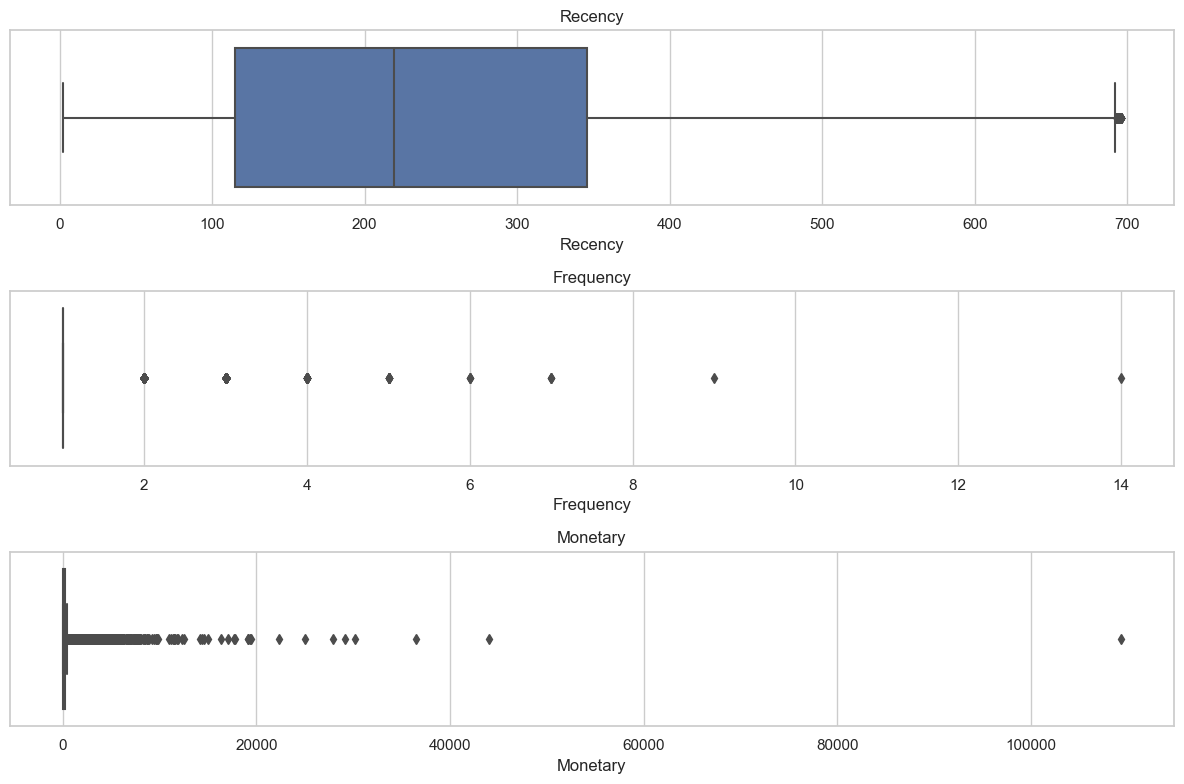

In [44]:
plt.figure(figsize=(12, 8))

# Boxplot pour la récence
plt.subplot(3, 1, 1)
sns.boxplot(x=rfm_df['recency'])
plt.title('Recency')
plt.xlabel('Recency')

# Boxplot pour la fréquence
plt.subplot(3, 1, 2)
sns.boxplot(x=rfm_df['frequency'])
plt.title('Frequency')
plt.xlabel('Frequency')

# Boxplot pour le montant
plt.subplot(3, 1, 3)
sns.boxplot(x=rfm_df['monetary'])
plt.title('Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

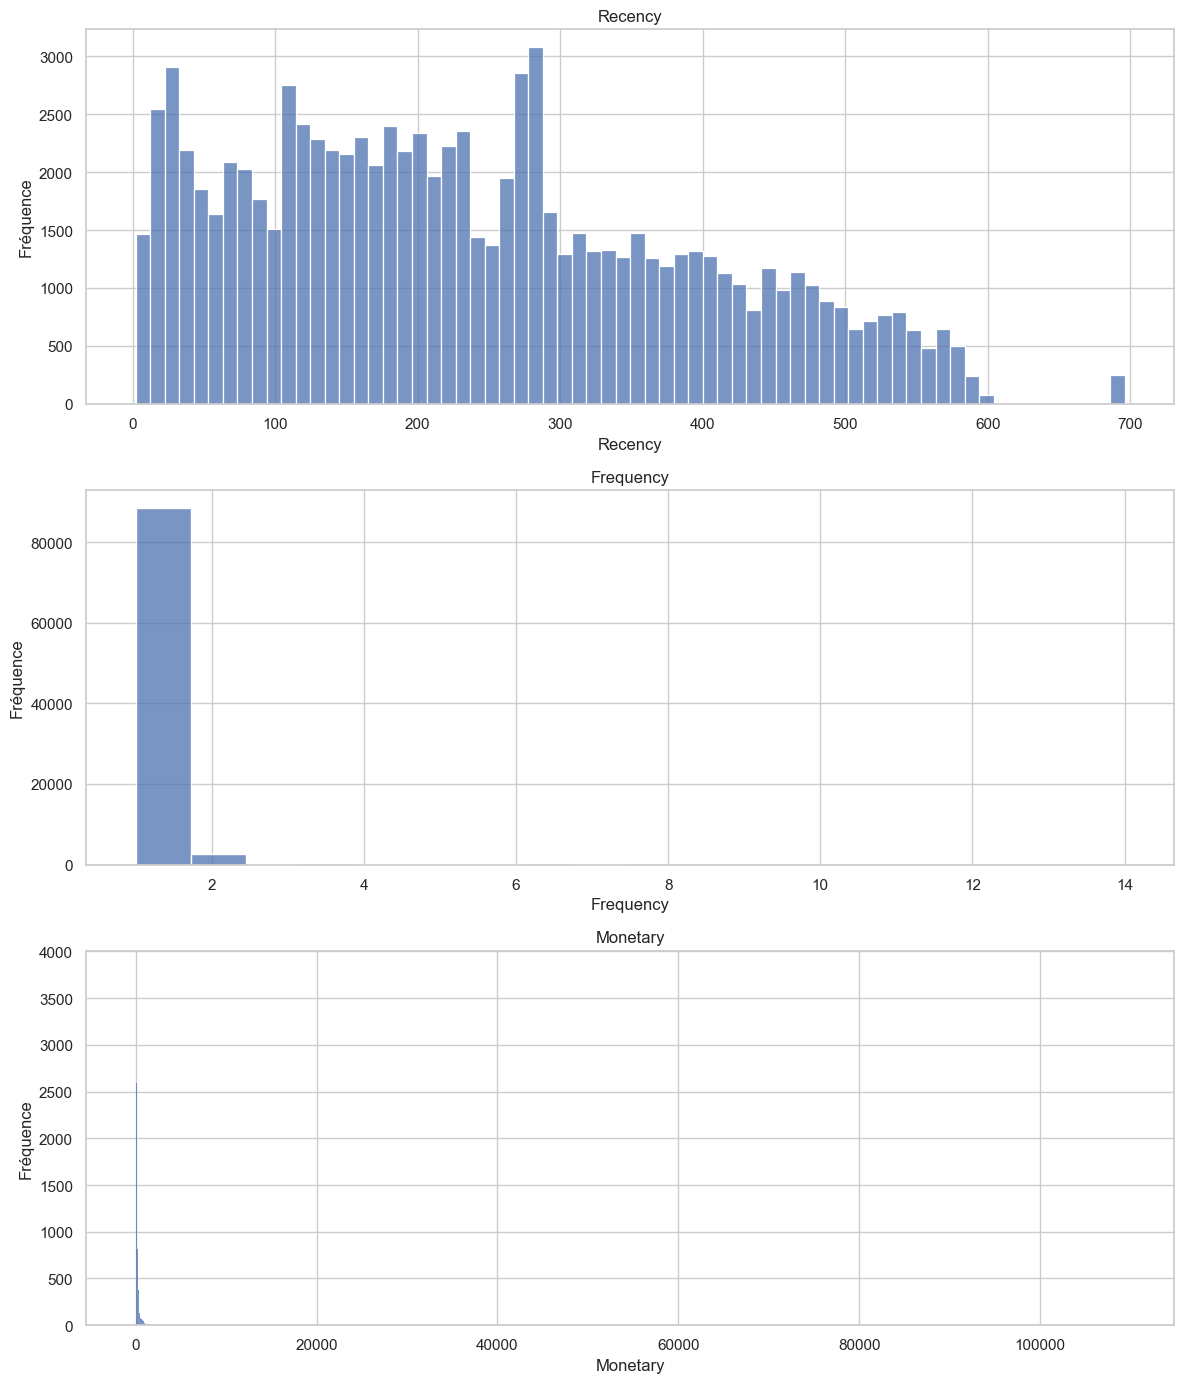

In [45]:
plt.figure(figsize=(12, 14))

plt.subplot(3, 1, 1)
sns.histplot(rfm_df['recency'])
plt.title('Recency')
plt.xlabel('Recency')
plt.ylabel('Fréquence')

plt.subplot(3, 1, 2)
sns.histplot(rfm_df['frequency'])
plt.title('Frequency')
plt.xlabel('Frequency')
plt.ylabel('Fréquence')

plt.subplot(3, 1, 3)
sns.histplot(rfm_df['monetary'])
plt.title('Monetary')
plt.xlabel('Monetary')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

- Création de variable produit par client

In [46]:
items_per_order = data.groupby(['customer_unique_id', 'order_id'])['order_item_id'].max().reset_index()
items_per_customer = items_per_order.groupby('customer_unique_id')['order_item_id'].sum().reset_index()
items_per_customer.rename(columns={'order_item_id': 'total_items'}, inplace=True)

features_df = items_per_customer


- Création du nombre de paiement par client

In [47]:
installments = data.groupby('customer_unique_id')['payment_installments'].mean().reset_index()
installments = installments.rename(columns={'payment_installments': 'average_installments'})
installments

features_df = features_df.merge(installments, on='customer_unique_id', how='inner')

- Création du rapport entre cout d'expedition et cout total

In [48]:
freight_sum_df = data.groupby('customer_unique_id')['freight_value'].sum().reset_index()
freight_sum_df.rename(columns={'freight_value': 'total_freight'}, inplace=True)
freight_df = pd.DataFrame()
freight_df['customer_unique_id'] = freight_sum_df['customer_unique_id']
freight_df['freight'] = round(freight_sum_df['total_freight'] / rfm_df['monetary'], 2)
                                                                                   
features_df = features_df.merge(freight_df, on='customer_unique_id', how='inner')

- Création du délai de livraison moyen par client

In [49]:
delivery_delay = data.groupby('customer_unique_id')['delivery_delay'].mean().reset_index()
delivery_delay = delivery_delay.rename(columns={'delivery_delay': 'average_delivery_delay'})
delivery_delay

features_df = features_df.merge(delivery_delay, on='customer_unique_id', how='inner')

- Création du score moyen donné par client

In [50]:
rating = data.groupby('customer_unique_id')['review_score'].mean().reset_index()
rating = rating.rename(columns={'review_score': 'average_review_score'})
rating

features_df = features_df.merge(rating, on='customer_unique_id', how='inner')

In [51]:
features_df.head()

,customer_unique_id,total_items,average_installments,freight,average_delivery_delay,average_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,8.0,0.08,6.0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,0.30,3.0,4.0
2,0000f46a3911fa3c0805444483337064,1,8.0,0.20,25.0,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,4.0,0.40,20.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,6.0,0.09,13.0,5.0


- Analyse des variables créées

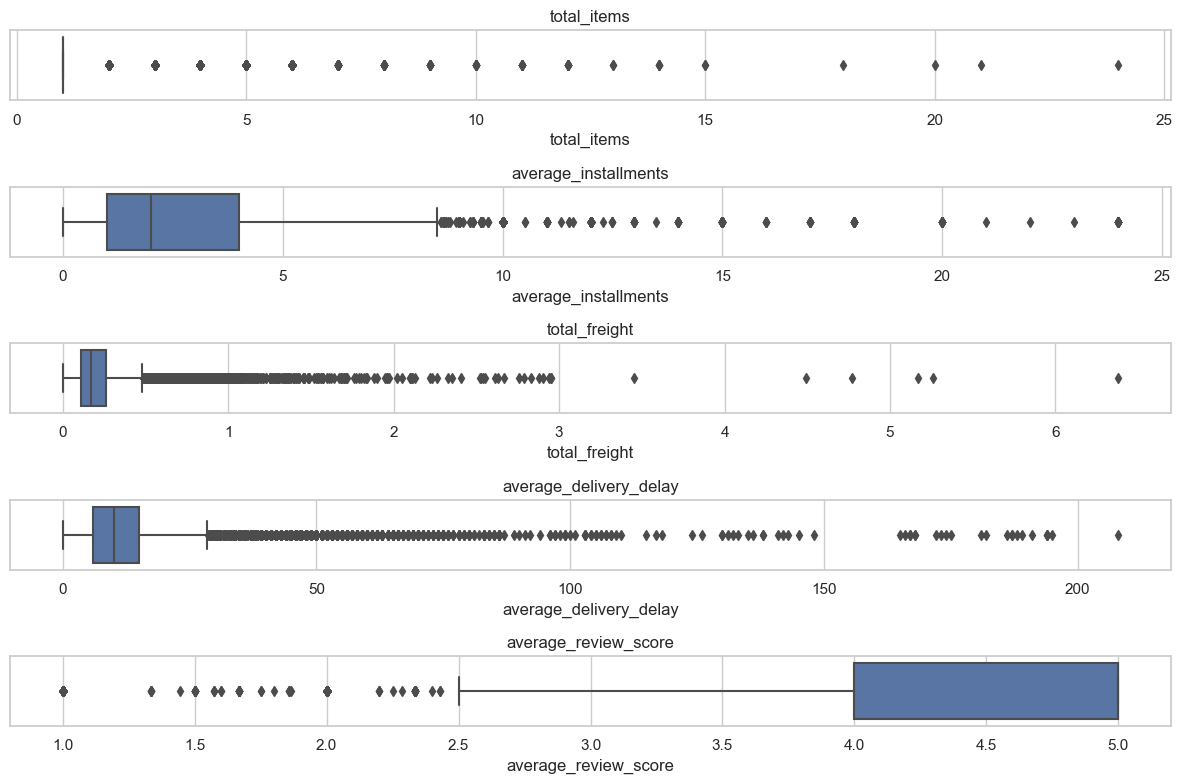

In [53]:
plt.figure(figsize=(12, 8))

# Boxplot pour la récence
plt.subplot(5, 1, 1)
sns.boxplot(x=features_df['total_items'])
plt.title('total_items')
plt.xlabel('total_items')

# Boxplot pour la fréquence
plt.subplot(5, 1, 2)
sns.boxplot(x=features_df['average_installments'])
plt.title('average_installments')
plt.xlabel('average_installments')

# Boxplot pour le montant total de l'expédition
plt.subplot(5, 1, 3)
sns.boxplot(x=features_df['freight'])
plt.title('total_freight')
plt.xlabel('total_freight')

# Boxplot pour le délai de livraison moyen
plt.subplot(5, 1, 4)
sns.boxplot(x=features_df['average_delivery_delay'])
plt.title('average_delivery_delay')
plt.xlabel('average_delivery_delay')

# Boxplot pour le score moyen de révision
plt.subplot(5, 1, 5)
sns.boxplot(x=features_df['average_review_score'])
plt.title('average_review_score')
plt.xlabel('average_review_score')

plt.tight_layout()
plt.show()


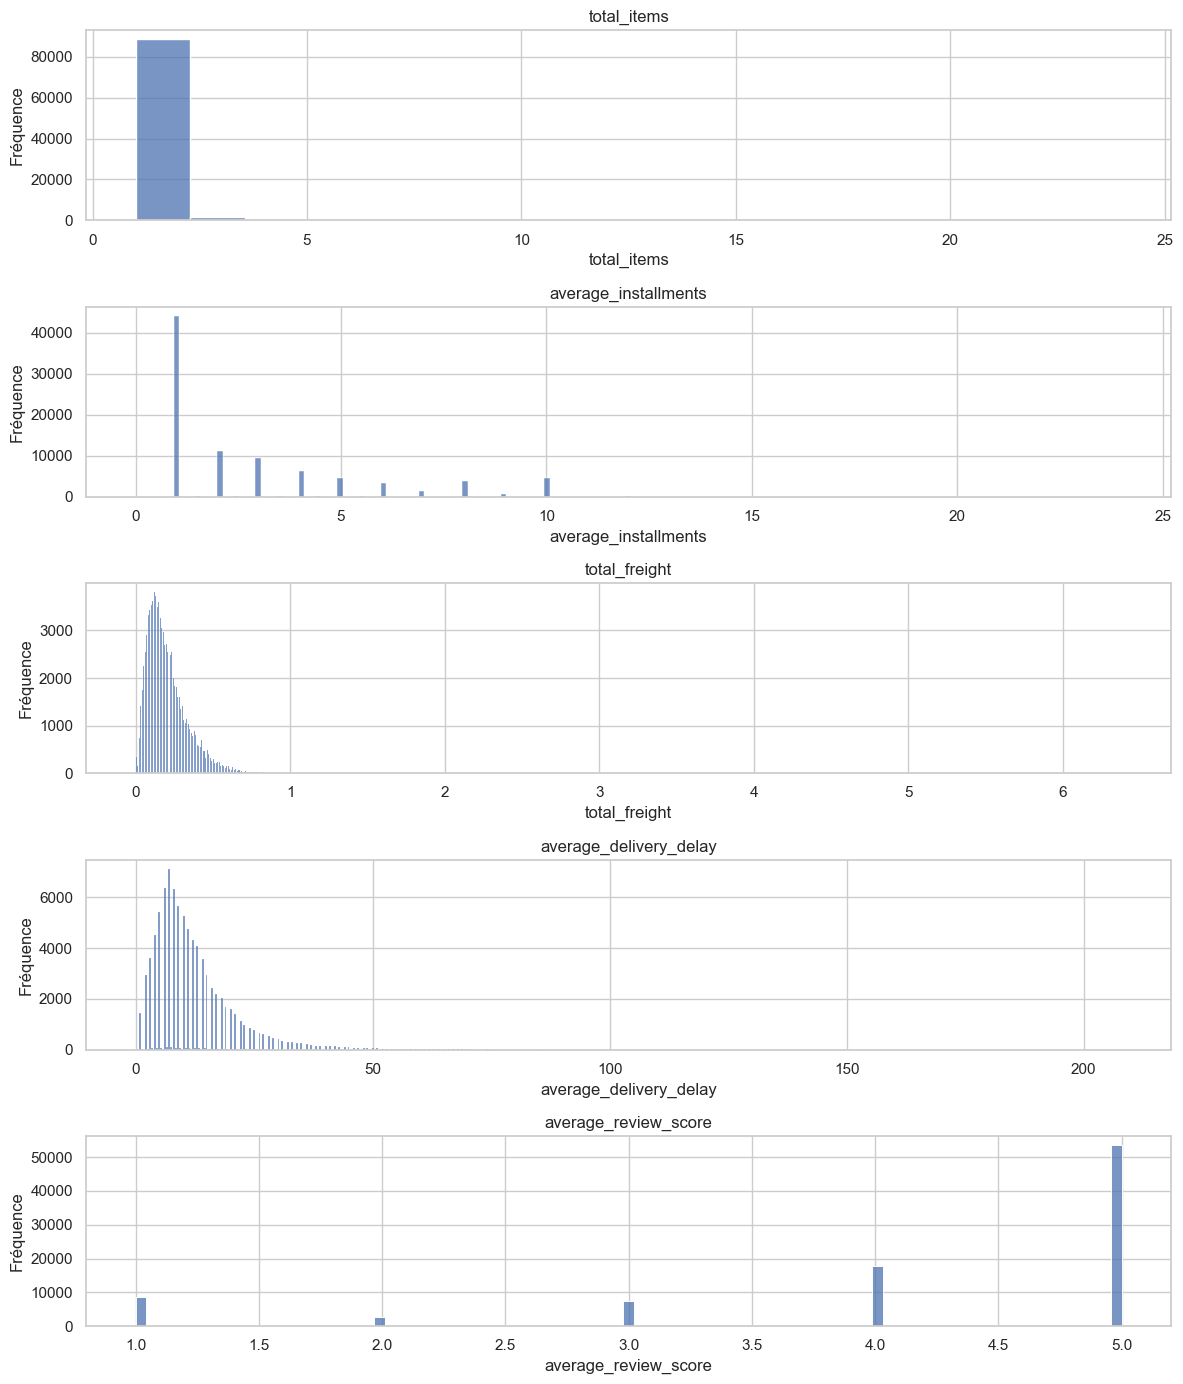

In [54]:
plt.figure(figsize=(12, 14))

plt.subplot(5, 1, 1)
sns.histplot(features_df['total_items'])
plt.title('total_items')
plt.xlabel('total_items')
plt.ylabel('Fréquence')

plt.subplot(5, 1, 2)
sns.histplot(features_df['average_installments'])
plt.title('average_installments')
plt.xlabel('average_installments')
plt.ylabel('Fréquence')

plt.subplot(5, 1, 3)
sns.histplot(features_df['freight'])
plt.title('total_freight')
plt.xlabel('total_freight')
plt.ylabel('Fréquence')

plt.subplot(5, 1, 4)
sns.histplot(features_df['average_delivery_delay'])
plt.title('average_delivery_delay')
plt.xlabel('average_delivery_delay')
plt.ylabel('Fréquence')

plt.subplot(5, 1, 5)
sns.histplot(features_df['average_review_score'])
plt.title('average_review_score')
plt.xlabel('average_review_score')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

- Export du fichier 

In [55]:
rfm_df.to_csv('./rfm.csv', index=False, sep=';', encoding='utf-8')

In [56]:
features_df.to_csv('./features.csv', index=False, sep=';', encoding='utf-8')

In [57]:
data.to_csv('./data.csv', index=False, sep=';', encoding='utf-8')